In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
# from scipy.ndimage import gaussian_filter

In [3]:
#HIGH RES
# par1min = -16
# par1max = 16
# par1step = .05
# par2min = -16
# par2max = 16
# par2step = .05
resdata = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/higher_res.dat')

# par1min = 0
# par1max = 16
# par1step = .05
# par2min = 0
# par2max = 16
# par2step = .05

# par1min = -10
# par1max = 20
# par1step = .05
# par2min = -20
# par2max = 10
# par2step = .05

#which has no extra for each dimension
# par1res = np.arange(par1min,par1max,par1step)
# par2res = np.arange(par2min,par2max,par2step)

#REGULAR RES
par1min_reg = -16
par1max_reg = 16
par1step_reg = .1
par2min_reg = -16
par2max_reg = 16
par2step_reg = .1

par1min = resdata[0,0]
par1max = resdata[0,1]
par1step = resdata[0,2]
par2min = resdata[1,0]
par2max = resdata[1,1]
par2step = resdata[1,2]

# # which goes an extra for each dimension
par1res = np.arange(par1min,par1max+0.00001,par1step)
par2res = np.arange(par2min,par2max+0.00001,par2step)
par1res_reg = np.arange(par1min_reg,par1max_reg+par1step_reg,par1step_reg)
par2res_reg = np.arange(par2min_reg,par2max_reg+par2step_reg,par2step_reg)
print(len(par1res))

3201


In [3]:
#define a set of colors for use in the figure
viridian = '#277C5E'
xanthous = '#F8AB25'
flame = '#E46A3A'
french_gray = '#BEBFC5'
airforce_blue = '#5F8EB0'

In [4]:
def get_avg_slice(indiv, type = None):
    if type == "multistability_check":
        data = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/%s/HPAgnosticAverage_highres_multistability.dat"%indiv)
        data = data.reshape((len(par2res),len(par1res),2,3))
        avgs = data[:,:,0,:]
        multistable = np.zeros_like(avgs[:,:,0])
        multistable[np.where(data[:,:,1,0]!=0)] = 1
        avgs = np.swapaxes(avgs,1,0)
        multistable = multistable.swapaxes(0,1)
        return avgs, multistable
    if type == "high_res":
        avgs = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/%s/HPAgnosticAverage_highres.dat"%indiv)
        avgs = avgs.reshape((len(par2res),len(par1res),3))
        avgs = np.swapaxes(avgs,1,0)
        return avgs
    if type == 'netchange':
        avgs = np.loadtxt("./Convenient HP Mechanisms/goodnetchange.dat")
        avgs = avgs.reshape((len(par2res),len(par1res),2))
        avgs = np.swapaxes(avgs,1,0)
        return avgs
    if type == 'newrho':
        data = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/%s/HPAgnosticAverage_highres_newrho.dat"%indiv)
        data = data.reshape((len(par2res),len(par1res),2,3))
        avgs = data[:,:,0,:]
        avgs = np.swapaxes(avgs,1,0)
        dutycycles = data[:,:,1,:]
        dutycycles = dutycycles.swapaxes(1,0)
        return avgs,dutycycles
    else:
        avgs = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/%s/HPAgnosticAverage.dat"%indiv)
        avgs = avgs.reshape((len(par2res_reg),len(par1res_reg),3))
        avgs = np.swapaxes(avgs,1,0)
        return avgs

def get_proxy_slice(indiv):
    '''returns a masked array with the averages of all the stable points, and a list of lambda functions for each oscillatory point, which takes the variables lb and ub and determines HP movement '''
    data = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/%s/HPAgnosticAverage_highres_newrho.dat"%indiv)
    data = data.reshape(len(par2res),len(par1res),2,3)
    avgs = data[:,:,0,:]
    avgs = avgs.swapaxes(0,1)
    duty_cycles = data[:,:,1,:]
    duty_cycles = duty_cycles.swapaxes(0,1)
    masked_stable_avgs = np.ma.masked_where(duty_cycles != 0,avgs)
    masked_oscillatory_avgs = np.ma.masked_where(duty_cycles == 0, avgs)
    masked_oscillatory_dutycycles = np.ma.masked_where(duty_cycles == 0, duty_cycles)

    return masked_stable_avgs, masked_oscillatory_avgs, masked_oscillatory_dutycycles

def get_osc_proxy(masked_oscillatory_avgs, masked_oscillatory_dutycycles,LB,UB):
    pred_HP_movement = (np.ones_like(masked_oscillatory_dutycycles)-masked_oscillatory_dutycycles)*LB + (masked_oscillatory_dutycycles)*UB - masked_oscillatory_avgs
    # pred_HP_movement = gaussian_filter(pred_HP_movement, sigma=.2) #doesn't really work, just hugs edges
    return pred_HP_movement
    

def get_pyloric_slice(indiv,high_res=False):
    if high_res:
        pyloricslice = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/pyloricslice_highres.dat'%indiv).reshape((len(par1res),len(par2res)))
    else:
        pyloricslice = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/pyloricslice.dat'%indiv).reshape((len(par1res_reg),len(par2res_reg)))
    pyloricslice = np.swapaxes(pyloricslice,1,0)
    return pyloricslice

def get_pyloric_outline(indiv,high_res=False):
    pyloricslice = get_pyloric_slice(indiv,high_res)
    borderlist_left = []
    borderlist_right = []
    for i in range(len(pyloricslice)):
        for j in range(2,len(pyloricslice[0])-1):
            if (pyloricslice[i,j-2] < .3 and pyloricslice[i,j-1] < .3 and pyloricslice[i,j]>=.3 and pyloricslice[i,j+1]>=.3):
                borderlist_left.append([par1res[j-1],par2res[i]])
                # print('left @ (%s,%s):'%(par2res[j],par1res[i]),pyloricslice[i,j-1],' right:',pyloricslice[i,j])
            if (pyloricslice[i,j-2] >= .3 and pyloricslice[i,j-1] >= .3 and pyloricslice[i,j]<.3 and pyloricslice[i,j+1]<.3):
                borderlist_right.append([par1res[j],par2res[i]])
    return [borderlist_left,borderlist_right[::-1]]


In [5]:
pyloric = get_pyloric_slice(19,high_res=True)
idxs = np.where(pyloric == np.max(pyloric))
avgs,dutycycles = get_avg_slice(19,type='newrho')
print(avgs[idxs],dutycycles[idxs])

ValueError: cannot reshape array of size 360000 into shape (321,321)

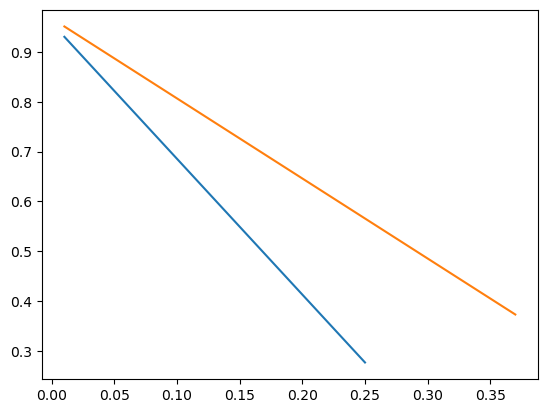

0.257165 0.371159


In [57]:
avg1 = avgs[idxs][0][0]
avg3 = avgs[idxs][0][2]
dc1 = dutycycles[idxs][0][0]
dc3 = dutycycles[idxs][0][2]
lb1s = np.arange(0.01,avg1,0.01)
ub1s = (avg1-((1-dc1)*lb1s))/dc1
lb3s = np.arange(0.01,avg3,0.01)
ub3s = (avg3-((1-dc3)*lb3s))/dc3

plt.rcParams['axes.facecolor'] = 'white'
plt.plot(lb1s,ub1s)
plt.plot(lb3s,ub3s)
plt.show()
# print(lb1s[20],ub1s[20]-lb1s[20])
# print(lb3s[19],ub3s[19]-lb3s[19])
print(avg1,avg3)

In [5]:
# def plot_outline(indiv,colorstring,high_res=False,ax=None):
#     outline = get_pyloric_outline(indiv,high_res)
#     for border in range(len(outline)):
#         if len(outline[border])!=0:
#             test = outline[border]
#             test.append(outline[(border+1)%(len(outline))][0])
#             test = np.array(test)
#             if ax==None:
#                 plt.plot(test[:,0],test[:,1],color=colorstring)
#             else:
#                 ax.plot(test[:,0],test[:,1],color=colorstring,linewidth=.5)

def plot_outline(indiv,colorstring):
    pyloricslice = get_pyloric_slice(indiv)
    plt.contour(par1res,par2res,pyloricslice,levels=[.3],colors=colorstring)

#the BIG useful function that calls all the other ones. Adjust aesthetic preferences within this funciton
def plot_HP_contours(indiv,LB,UB,neuronidxs,color,axis=None,plotavgs=True,tolerance = 0):
    if (len(neuronidxs) > 1):
        plotavgs = False
    masked_stable_avgs, masked_oscillatory_avgs, masked_oscillatory_dutycycles = get_proxy_slice(indiv)
    if axis==None:
        if plotavgs:
            plt.rcParams['axes.facecolor'] = french_gray
        else:
            plt.rcParams['axes.facecolor'] = 'white'
        plot_outline(indiv, 'k', True, ax=axis)
        if plotavgs:
            plt.pcolormesh(par1res,par2res,masked_stable_avgs[:,:,neuronidxs[0]],cmap="Blues")
            plt.colorbar()
        for i in range(len(neuronidxs)):
            neuronidx = neuronidxs[i]
            osc_proxy = get_osc_proxy(masked_oscillatory_avgs,masked_oscillatory_dutycycles,LB[i],UB[i])
            if LB[i] != UB[i]:
                plt.contourf(par1res,par2res,masked_stable_avgs[:,:,neuronidx],levels=[LB[i],UB[i]],colors=color[i],corner_mask=False)
            else:
                plt.contour(par1res,par2res,masked_stable_avgs[:,:,neuronidx],levels=[LB[i]],colors=color[i],corner_mask=False)
            if tolerance == 0:
                plt.contour(par1res,par2res,osc_proxy[:,:,neuronidx],levels=[0],colors=color[i],corner_mask=False)
            else: 
                plt.contourf(par1res,par2res,osc_proxy[:,:,neuronidx],levels=[-tolerance,tolerance],colors=color[i],corner_mask=False)
            # plt.contour(par1res,par2res,masked_oscillatory_avgs[:,:,neuronidx],levels=[LB[i]],colors=color[i]) 
            
    else:
        if plotavgs:
            axis.rcParams['axes.facecolor'] = french_gray
        else:
            axis.rcParams['axes.facecolor'] = 'white'
        plot_outline(indiv, 'k', True, ax=axis)
        if plotavgs:
            axis.pcolormesh(par1res,par2res,masked_stable_avgs[:,:,neuronidx],cmap="Blues")
            axis.colorbar()
        for i in range(len(neuronidxs)):
            neuronidx = neuronidxs[i]
            osc_proxy = get_osc_proxy(masked_oscillatory_avgs,masked_oscillatory_dutycycles,LB[i],UB[i])
            if LB[i] != UB[i]:
                axis.contourf(par1res,par2res,masked_stable_avgs[:,:,neuronidx],levels=[LB[i],UB[i]],colors=color[i],corner_mask=False)
            else:
                axis.contour(par1res,par2res,masked_stable_avgs[:,:,neuronidx],levels=[LB[i]],colors=color[i],corner_mask=False)
            if tolerance == 0:
                axis.contour(par1res,par2res,osc_proxy[:,:,neuronidx],levels=[0],colors=color[i],corner_mask=False)
            else: 
                axis.contourf(par1res,par2res,osc_proxy[:,:,neuronidx],levels=[-tolerance,tolerance],colors=color[i],corner_mask=False) 
    

    
    

In [9]:
stepsize = 0.05
dur = 100000
time = np.arange(0,dur,stepsize)
repeats = int(200/20)
# traj = np.loadtxt("./Convenient HP Mechanisms/testrhobiastrack.dat").reshape((repeats,len(time),2))
traj = np.loadtxt("./Convenient HP Mechanisms/oldbiastracktest.dat").reshape((repeats,len(time),2))
    

OSError: ./Convenient HP Mechanisms/oldbiastracktest.dat not found.

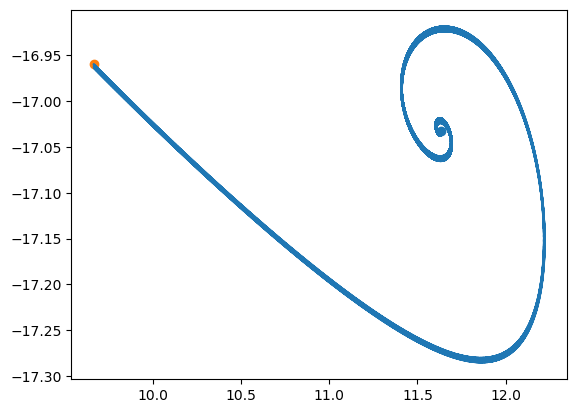

In [124]:
plt.plot(traj[1,-1000000:,0],traj[1,-1000000:,1])
plt.scatter(traj[1,-1,0],traj[1,-1,1])
plt.scatter(traj[1,-1000000,0],traj[1,-1000000,1])

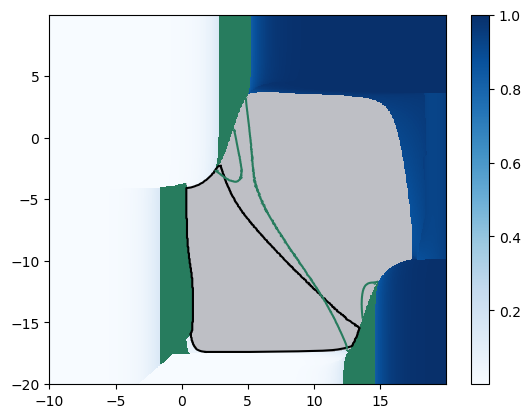

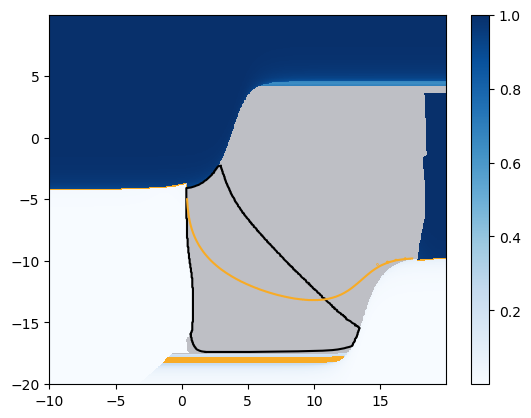

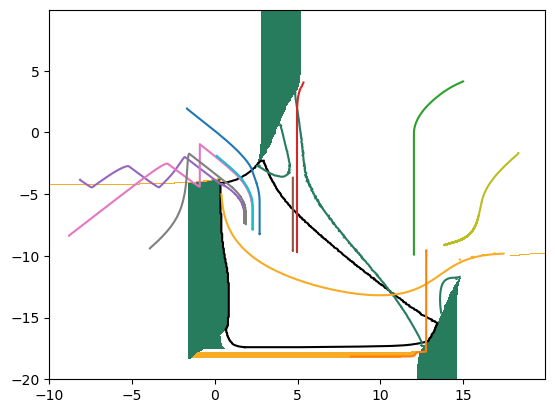

In [152]:
[[lb1,ub1],[lb3,ub3]] = [[0.154018,0.818217],[0.244852,0.374831]]
# [[lb1,ub1],[lb3,ub3]] = [[lb1s[-1],ub1s[-1]],[lb3s[-1],ub3s[-1]]]
plot_HP_contours(19,[lb1],[ub1],[0],[viridian],plotavgs=True)
plt.show()
plot_HP_contours(19,[lb3],[ub3],[2],[xanthous],plotavgs=True)
plt.show()
plot_HP_contours(19,[lb1,lb3],[ub1,ub3],[0,2],[viridian,xanthous],plotavgs=True,tolerance=0)
for i in range(repeats):
    plt.plot(traj[i,:,0],traj[i,:,1])


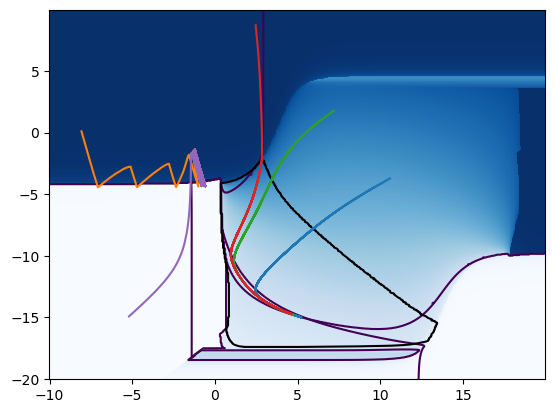

In [141]:
avgs,dutycycles = get_avg_slice(19,'newrho')
plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plt.contour(par1res,par2res,avgs[:,:,2],levels=[.2])
plt.contour(par1res,par2res,avgs[:,:,0],levels=[.17])
plot_outline(19,'k',True)
for i in range(repeats):
    plt.plot(traj[i,:,0],traj[i,:,1])

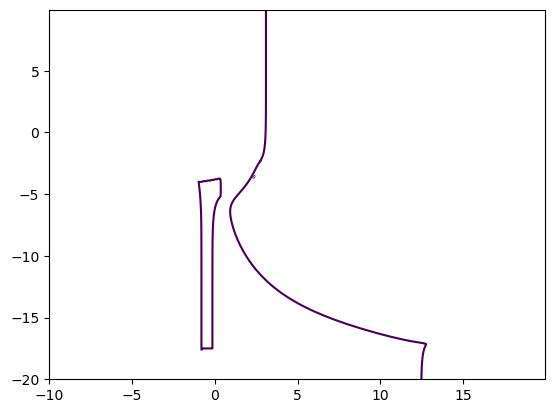

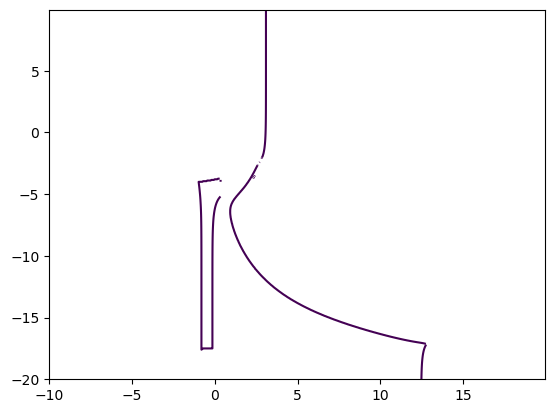

In [80]:
avgs = get_avg_slice(19,type='newrho')
plt.contour(par1res,par2res,avgs[:,:,0],levels=[lb1])
plt.show()
stable_avgs, osc_avgs, osc_DC = get_proxy_slice(19)
plt.contour(par1res,par2res,stable_avgs[:,:,0],levels=[lb1])
plt.contour(par1res,par2res,osc_avgs[:,:,0],levels=[lb1],corner_mask=False)
plt.show()

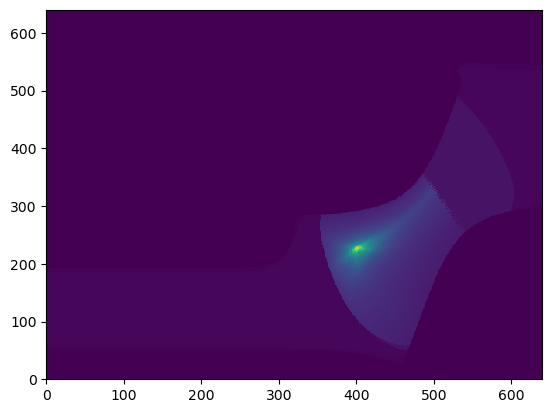

In [47]:
slice = get_pyloric_slice(52,True)
plt.pcolormesh(slice)

In [52]:
x = np.linspace(0,10,1000)
y = np.sin(x)
plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plt.plot(x,y,color=viridian)
plt.plot(x+1,y,color=xanthous)
plt.plot(x+2,y,color=flame)
plt.colorbar()
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plt.plot(x,y,color=viridian)
plt.plot(x+1,y,color=xanthous)
plt.plot(x+2,y,color=flame)
plt.colorbar()
plt.show()

NameError: name 'avgs' is not defined

In [6]:
#write a function to draw what would be the "nullclines" of a given HP mechanism
#(in other words, determine the point with an average which is the closest to that HP mechanism's target)

def nullcline(par, target, averages, tolerance = 0.0015,direction='leftright'):
    #averages should be full matrix, function separates out the relevant parts
    #tolerance is the maximum distance away from the target that is considered "close" (i.e. won't cause inertia)
    nullcline_pts = []
    if par == 'par1':
        vals = averages[:,:,0]
    elif par == 'par2': 
        vals = averages[:,:,2]
    if direction == 'leftright':
        for i in range(len(vals)):
            for j in range(len(vals[0])-1):
                if (vals[i,j]-target>-tolerance) and (vals[i,j]-target < 0) and (vals[i,j+1]-target > 0): #also covers the stability criteria
                    nullcline_pts.append([par1res[j],par2res[i]])
    elif direction == 'updown':
        for j in range(len(vals[0])):
            for i in range(len(vals)-1):
                if (vals[i,j]-target>-tolerance) and (vals[i,j]-target < 0) and (vals[i+1,j]-target > 0): #also covers the stability criteria
                    nullcline_pts.append([par1res[j],par2res[i]])
    else:
        raise TypeError('not a valid parameter specification')
    #now order the points that have been collected, starting from the corner and repeatedly adding the closest point
    nullcline_pts = np.array(nullcline_pts)
    return nullcline_pts

def nearest_neighbor_ordering(ptlist,color='black',lineseparator = .5):
    nullcline_pts = ptlist
    ordered_nullcline_pts = [[]]
    ordered_nullcline_pts[0].append(nullcline_pts[0]) #take the first point 
    nullcline_pts = nullcline_pts[1:]          #and then remove it from further consideration
    num_pts = len(nullcline_pts)
    line_count = 0
    k = 1
    # print(nullcline_pts)
    for i in range(0,num_pts):
        # print(nullcline_pts - ordered_nullcline_pts[line_count][k-1])
        dists = np.linalg.norm(nullcline_pts-np.array(ordered_nullcline_pts[line_count][k-1]),axis=1) #find every point's distance from the previously collected point
        # print('lendists:',len(dists))
        closest_idx = np.where(dists == np.min(dists))[0]
        if np.min(dists) > lineseparator:
            line_count += 1
            k = 0
            ordered_nullcline_pts.append([])
            lowest = nullcline_pts[np.where(nullcline_pts[:,0]==np.min(nullcline_pts[:,0]))[0]]
            lowestleft_idx = np.where(lowest[:,1]==np.min(lowest[:,1]))[0]
            closest_idx = lowestleft_idx #start at lowest remaining pt
            # print('starting new line:',nullcline_pts[closest_idx][0][:])
        # else: 
            # print('continue line:', nullcline_pts[closest_idx][0][:])
        ordered_nullcline_pts[line_count].append(nullcline_pts[closest_idx][0][:]) #take the one closest to previously collected
        # print('lenpts:',len(nullcline_pts))
        # print(closest_idx)
        if (len(closest_idx) > 1):
            print('lenflag')
        nullcline_pts = np.delete(nullcline_pts, (closest_idx[0]), axis=0)#and then remove it from further consideration
        k += 1
    for i in range(line_count+1):
        ordered_pts = np.array(ordered_nullcline_pts[i])
        # print(ordered_pts)
        plt.plot(ordered_pts[:,0],ordered_pts[:,1],color=color)

def plot_nullcline(par,target,averages, color,tolerance=.1, lineseparator = .5):
    leftright = nullcline(par,target,averages,tolerance,direction='leftright')
    updown = nullcline(par,target,averages,tolerance,direction='updown')
    nullcline_pts = np.unique(np.concatenate((leftright,updown)),axis=0)
    ordered_nullcline_pts = [[]]
    ordered_nullcline_pts[0].append(nullcline_pts[0]) #take the first point 
    nullcline_pts = nullcline_pts[1:]          #and then remove it from further consideration
    num_pts = len(nullcline_pts)
    line_count = 0
    k = 1
    # print(nullcline_pts)
    for i in range(0,num_pts):
        # print(nullcline_pts - ordered_nullcline_pts[line_count][k-1])
        dists = np.linalg.norm(nullcline_pts-np.array(ordered_nullcline_pts[line_count][k-1]),axis=1) #find every point's distance from the previously collected point
        # print('lendists:',len(dists))
        closest_idx = np.where(dists == np.min(dists))[0]
        if np.min(dists) > lineseparator:
            line_count += 1
            k = 0
            ordered_nullcline_pts.append([])
            lowest = nullcline_pts[np.where(nullcline_pts[:,0]==np.min(nullcline_pts[:,0]))[0]]
            lowestleft_idx = np.where(lowest[:,1]==np.min(lowest[:,1]))[0]
            closest_idx = lowestleft_idx #start at lowest remaining pt
            # print('starting new line:',nullcline_pts[closest_idx][0][:])
        # else: 
            # print('continue line:', nullcline_pts[closest_idx][0][:])
        ordered_nullcline_pts[line_count].append(nullcline_pts[closest_idx][0][:]) #take the one closest to previously collected
        # print('lenpts:',len(nullcline_pts))
        # print(closest_idx)
        if (len(closest_idx) > 1):
            print('lenflag')
        nullcline_pts = np.delete(nullcline_pts, (closest_idx[0]), axis=0)#and then remove it from further consideration
        k += 1
    for i in range(line_count+1):
        ordered_pts = np.array(ordered_nullcline_pts[i])
        # print(ordered_pts)
        plt.plot(ordered_pts[:,0],ordered_pts[:,1],color=color)
    


    

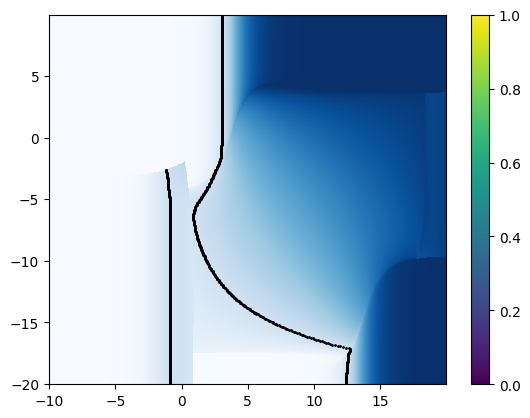

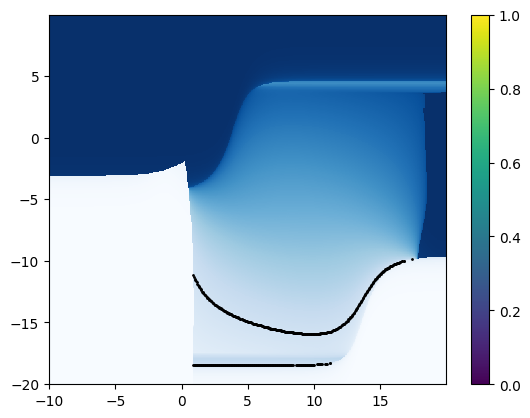

In [244]:
# tune the tolerance to make sure we get all the points
tolerance = 0.025

test1 = nullcline('par1',0.2,avgs,tolerance=tolerance)

plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plt.scatter(test1[:,0],test1[:,1],color='k',s=1)
plt.colorbar()
plt.show()

test2 = nullcline('par2',0.2,avgs,tolerance=tolerance)

plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plt.scatter(test2[:,0],test2[:,1],color='k',s=1)
plt.colorbar()
plt.show()


[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[90]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]
[179]
[180]
[181]
[182]
[183]
[184]
[185

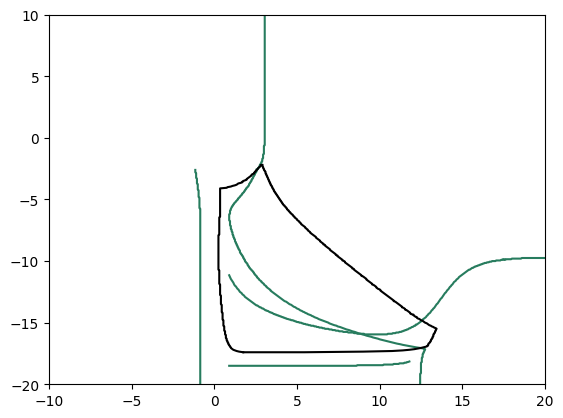

In [351]:
#tune the line separator to make the points plot smoothly
lineseparator = 1.5

plt.xlim(par1min,par1max)
plt.ylim(par2min,par2max)
# plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plot_nullcline('par1',.2,avgs,viridian,tolerance,lineseparator)
# plt.plot(test[:,0],test[:,1],color='k')
# plt.colorbar()
# plt.scatter(test1[:,0],test1[:,1],color=viridian,s=1)
# plot_outline(19,'black',True)
# plt.show()
# plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plot_nullcline('par2',.2,avgs,viridian,tolerance,lineseparator)
# plt.colorbar()
# plt.scatter(test2[:,0],test2[:,1],color=viridian,s=1)
plot_outline(19,'black',True)
plt.show()

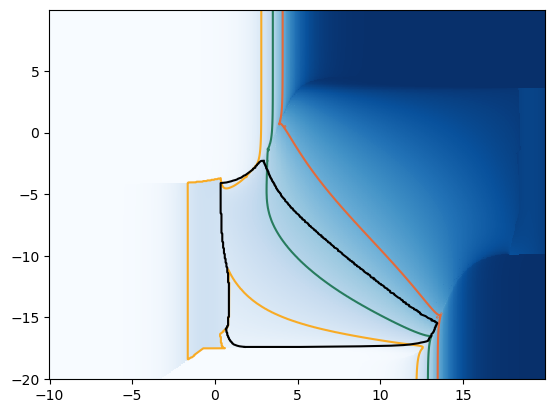

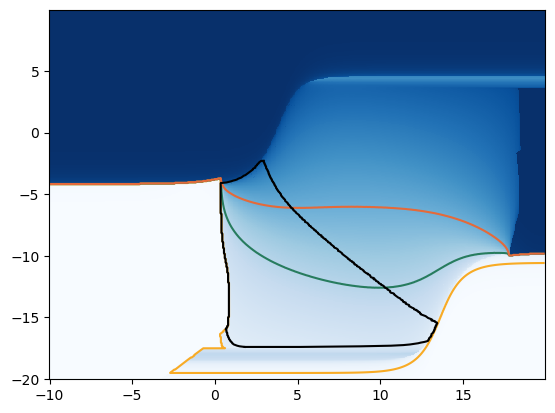

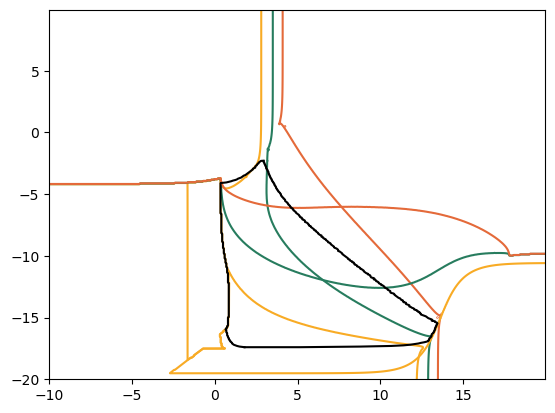

In [10]:
# plt.xticks(np.linspace(par1min,par1max,num=7,endpoint=True))
# plt.yticks(np.linspace(par2min,par2max,num=7,endpoint=True))
plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plt.contour(par1res,par2res,avgs[:,:,0],levels=[.15,.3,.5],colors=[xanthous,viridian,flame])
plot_outline(19,'black',True)
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plt.contour(par1res,par2res,avgs[:,:,2],levels=[.03,.3,.5],colors=[xanthous,viridian,flame])
plot_outline(19,'black',True)
plt.show()
plt.contour(par1res,par2res,avgs[:,:,0],levels=[.15,.3,.5],colors=[xanthous,viridian,flame])
plt.contour(par1res,par2res,avgs[:,:,2],levels=[.03,.3,.5],colors=[xanthous,viridian,flame])
plot_outline(19,'black',True)
plt.show()

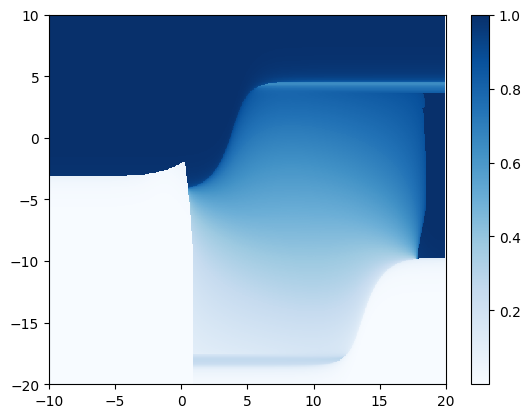

lenflag
lenflag
lenflag


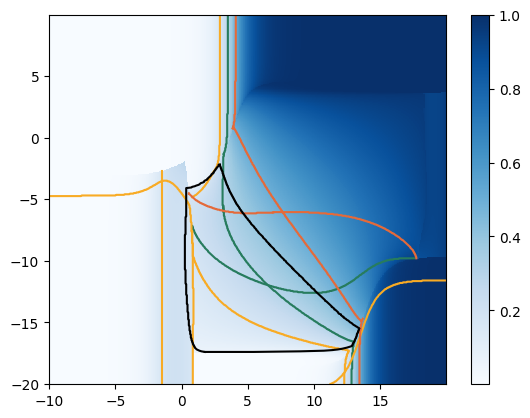

In [575]:
#test out different targets to get a representative spread
tolerance = 0.1

# LPtarget = .5
# PDtarget = .5

plt.xlim(par1min,par1max)
plt.ylim(par2min,par2max)

plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plt.colorbar()
plt.show()

plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plt.colorbar()

# test1 = nullcline('par1',LPtarget,avgs,tolerance)
# test2 = nullcline('par2',PDtarget,avgs,tolerance)
# plt.scatter(test1[:,0],test1[:,1],s=1)
# plt.scatter(test2[:,0],test2[:,1],s=1)

plot_nullcline('par1',.3,avgs,viridian,tolerance,lineseparator)
plot_nullcline('par2',.3,avgs,viridian,tolerance,lineseparator)
plot_nullcline('par1',0.17,avgs,xanthous,tolerance,lineseparator)
plot_nullcline('par2',0.01,avgs,xanthous,tolerance,lineseparator)
plot_nullcline('par1',.5,avgs,flame,tolerance,lineseparator)
plot_nullcline('par2',.5,avgs,flame,tolerance,lineseparator)
plot_outline(19,'black',True)
plt.show()

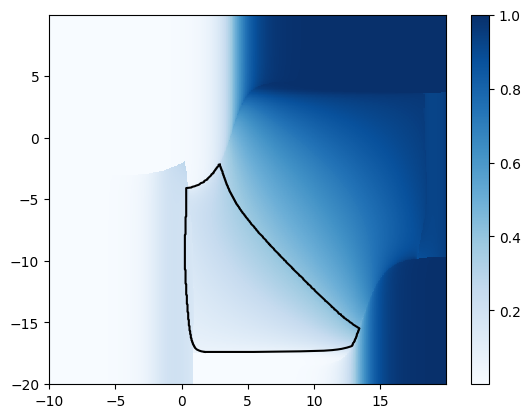

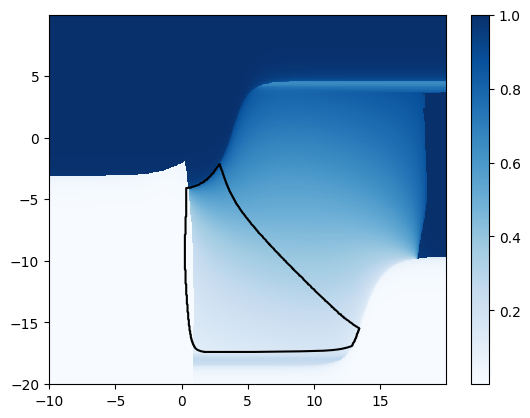

In [110]:
for i in range(19,20):
    # avgs,multistability = get_avg_slice(i,multistability_check=True) #DO NOT UNCOMMENT PYTHON IS THE ONLY PLACE THIS DATA EXISTS
    # outline = get_pyloric_outline(i,True)
    plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
    # plt.scatter(circuitB1,circuitB3,color='white')
    plot_outline(i,'black',True)
    plt.colorbar()
    plt.show()
    plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
    # plt.scatter(circuitB1,circuitB3,color='white')
    plot_outline(i,'black',True)
    plt.colorbar()
    plt.show()

Re-do to see if individual 82 is a better looking/cleaner half-success

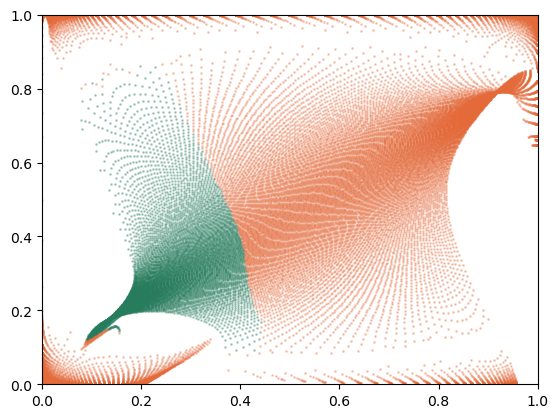

TypeError: get_avg_slice() got an unexpected keyword argument 'multistability_check'

In [198]:
#first testing with data already gathered
indiv = 19
plt.xlim(0,1)
plt.ylim(0,1)
uniquevals(indiv,evaluate=False,plot=True)
LPtarget = .18
PDtarget = .85
avgs = get_avg_slice(indiv,multistability_check=False) 
plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plot_nullcline('par1',LPtarget,avgs,xanthous,tolerance=.25,lineseparator=.25)
plot_outline(indiv,'black',False)
plt.colorbar()
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plot_nullcline('par2',PDtarget,avgs,xanthous,tolerance=.25,lineseparator=.25)
plot_outline(indiv,'black',False)
plt.colorbar()
plt.show()
plt.xlim(par1min,par1max)
plt.ylim(par2min,par2max)
# test1 = nullcline('par1',.5,avgs,tolerance = .05,direction='leftright')
# test2 = nullcline('par2',.3,avgs,tolerance = .05,direction='updown')
# plt.scatter(test1[:,0],test1[:,1],s=1)
# plt.scatter(test2[:,0],test2[:,1],s=1)
plot_nullcline('par1',LPtarget,avgs,xanthous,tolerance=.5,lineseparator=.5)
plot_nullcline('par2',PDtarget,avgs,xanthous,tolerance=.5,lineseparator=.5)
plot_outline(indiv,'black',False)
plt.show()


[[-9.800000000000022, 6.89999999999992], [-9.600000000000023, 6.799999999999919], [-9.400000000000023, 6.699999999999918], [-9.000000000000025, 6.59999999999992], [-8.700000000000026, 6.499999999999922], [-8.200000000000028, 6.39999999999992], [-7.900000000000029, 6.299999999999919], [-7.50000000000003, 6.199999999999921], [-7.000000000000032, 6.099999999999923], [-6.700000000000033, 5.999999999999922], [-5.900000000000036, 5.89999999999992], [-6.200000000000035, 5.89999999999992], [-5.200000000000038, 5.7999999999999226], [-5.600000000000037, 5.7999999999999226], [-5.100000000000039, 5.699999999999925], [-5.300000000000038, 5.699999999999925], [-4.300000000000042, 5.599999999999923], [-4.6000000000000405, 5.599999999999923], [-3.600000000000044, 5.499999999999922], [-3.8000000000000433, 5.499999999999922], [-4.300000000000042, 5.499999999999922], [-2.9000000000000465, 5.399999999999924], [-3.2000000000000455, 5.399999999999924], [-3.4000000000000448, 5.399999999999924], [-3.6000000000

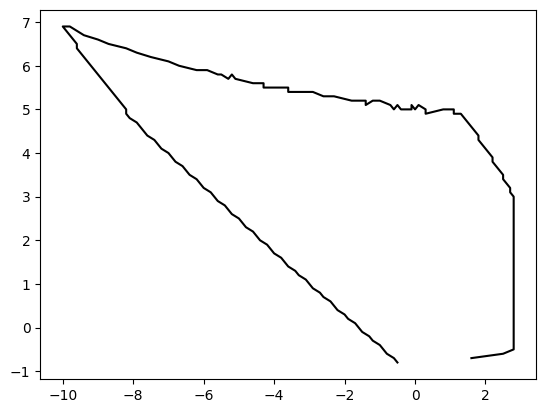

In [488]:
#test out nearest neighbor method
[left,right] = get_pyloric_outline(82)
print(right)
pyloric_outline = np.concatenate((left,right),axis=0)
print(len(left),len(right),len(pyloric_outline))
nearest_neighbor_ordering(pyloric_outline,lineseparator=1)

Ask whether there are any values which uniquely occur in the pyloric region

In [228]:
indiv = 0

pyloricslice = get_pyloric_slice(indiv)
avgs = get_avg_slice(indiv)

idx = 19
testpyloricavg = avgs[np.where(pyloricslice>=.3)][:,0::2][idx]
nonpyloric = avgs[np.where(pyloricslice<.3)][:,0::2]

dists = np.zeros(len(nonpyloric))
k=0
for j in nonpyloric:
    dists[k] = np.linalg.norm(testpyloricavg-j)
    if dists[k] < 0.005:
        print(testpyloricavg," ,", j, ":", dists[k])
    k += 1
        

In [33]:
def uniquevals(indiv,tolerance = 0.03,evaluate = False,plot=True,ax=None,progress=False,high_res=True):
    if high_res:
        stype = 'high_res'
    else:
        stype = None
    pyloricslice = get_pyloric_slice(indiv, high_res)
    avgs = get_avg_slice(indiv,type=stype)
    # maskingslice = np.repeat(pyloricslice,3,axis=1).reshape((len(pyloricslice),len(pyloricslice[0]),3))
    # pyloricavgs = np.ma.masked_where(maskingslice<0.3,avgs)
    pyloricavgs = avgs[np.where(pyloricslice>=.3)][:,0::2]

    # num_nonpyloric = len(np.where(maskingslice < 0.3)[0])
    # nonpyloricavgs = np.ma.masked_where(maskingslice>=0.3,avgs)
    nonpyloricavgs = avgs[np.where(pyloricslice<.3)][:,0::2]

    if plot and (ax==None):
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.scatter(nonpyloricavgs[:,0],nonpyloricavgs[:,1],color='r',alpha=.2,s=1)
        plt.scatter(pyloricavgs[:,0],pyloricavgs[:,1],color='g',alpha=.2,s=1)
        plt.show()
    if plot and (ax!=None):
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.scatter(nonpyloricavgs[:,0],nonpyloricavgs[:,1],color='r',alpha=.2,s=1)
        ax.scatter(pyloricavgs[:,0],pyloricavgs[:,1],color='g',alpha=.2,s=1)

    solvable = False

    if evaluate:
        if high_res == False: #then, conceivable to run through and check every point in the pyloric list
            for i in range(len(pyloricavgs)):
                if progress:
                    print(i)
                dists = np.linalg.norm(nonpyloricavgs-pyloricavgs[i],axis=1)
                if np.min(dists)>tolerance:
                    solvable = True
                    if progress:
                        print(pyloricavgs[i],nonpyloricavgs[np.where(dists==np.min(dists))],np.min(dists))
                    break
        else: #takes too long to check every point, so we have a more complicated scheme (see markdown)
            elimination_pyl_list = np.copy(pyloricavgs)
            while len(elimination_pyl_list>0):
                pyl_pt = elimination_pyl_list[0]
                dists_pyl = np.linalg.norm(nonpyloricavgs-pyl_pt,axis=1)
                if np.min(dists_pyl)>tolerance:
                    solvable = True
                    if progress:
                        print(pyl_pt,nonpyloricavgs[np.where(dists_pyl==np.min(dists_pyl))],np.min(dists))
                    break
                else:
                    nonpyl_pt = nonpyloricavgs[np.where(dists_pyl==np.min(dists_pyl))]
                    dists_nonpyl = np.linalg.norm(elimination_pyl_list-nonpyl_pt,axis=1)
                    elimination_pyl_list = elimination_pyl_list[dists_nonpyl>tolerance]
                    if progress:
                        print(len(elimination_pyl_list))
            print(solvable)
    return solvable

### Alternative Scheme Pseudocode:

pyloric point

check if it is far from all nonpyloric

if its not, identify closest nonpyloric point

eliminate all pyloric points within threshold of it

next remaining pyloric point and repeat

### Why not just do the grid style?:

grid style is subject to boundary weirdness. If there is a pyloric point that is very close to a nonpyloric point but just happens to be on the wrong
side of the grid, then it would count it as far away

In [25]:
#figure out what is the lowest number of successful rows that got completed across the dataset for restarting w/o wasting compute resources
for indiv in range(12,100):
    dattest = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/pyloricslice_highres.dat'%indiv,max_rows=1087)
    print(indiv, ' successful')

12  successful
13  successful
14  successful
15  successful
16  successful
17  successful
18  successful
19  successful
20  successful
21  successful
22  successful
23  successful
24  successful
25  successful
26  successful
27  successful
28  successful
29  successful
30  successful
31  successful
32  successful
33  successful
34  successful
35  successful
36  successful
37  successful
38  successful
39  successful
40  successful
41  successful
42  successful
43  successful
44  successful
45  successful
46  successful
47  successful
48  successful
49  successful
50  successful
51  successful
52  successful
53  successful
54  successful
55  successful
56  successful
57  successful
58  successful
59  successful
60  successful
61  successful
62  successful
63  successful
64  successful
65  successful
66  successful
67  successful
68  successful
69  successful
70  successful
71  successful
72  successful
73  successful
74  successful
75  successful
76  successful
77  successful
78  succes

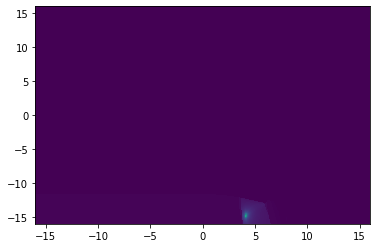

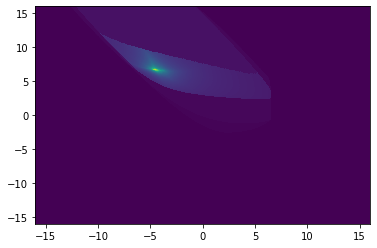

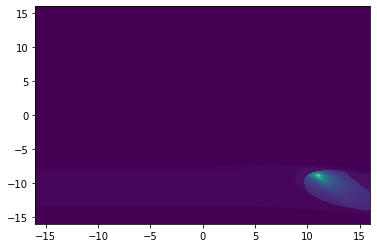

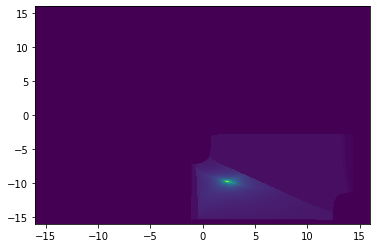

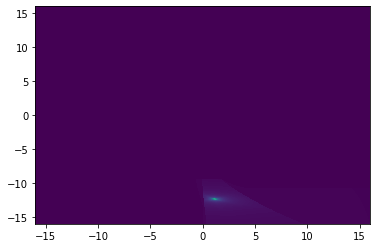

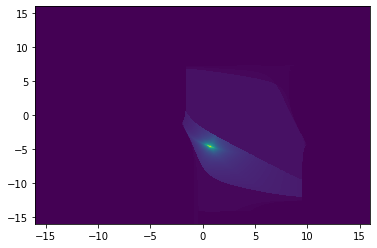

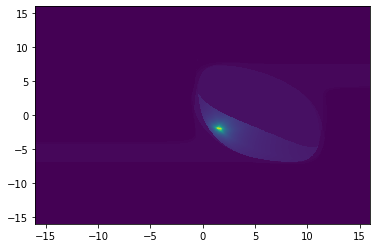

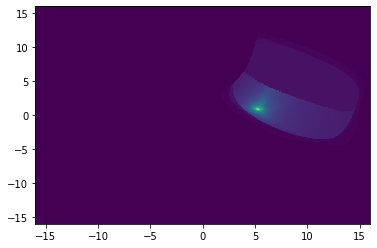

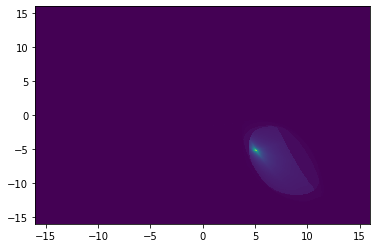

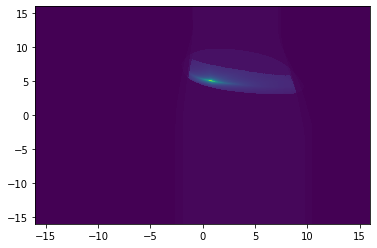

In [11]:
for indiv in range(10):
    dat = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/pyloricslice_highres.dat'%indiv)
    dat = dat.swapaxes(0,1)
    im = plt.pcolormesh(par1res,par2res,dat,shading='auto')
    plt.show()

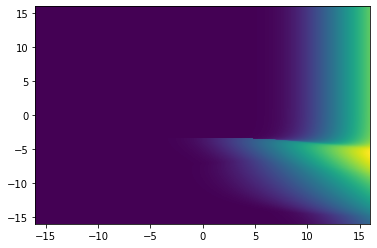

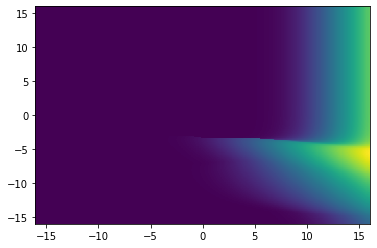

In [ ]:
#compare given highres averages slice to the low res version (some slight differences probably due to multistability and initialization?)
indiv = 2
avgs = get_avg_slice(2,type='high_res')
avgs_low = get_avg_slice(2)

plt.pcolormesh(par1res,par2res,avgs[:,:,0],shading='auto')
plt.show()
plt.pcolormesh(par1res_reg,par2res_reg,avgs_low[:,:,0],shading='auto')
plt.show()

In [48]:
solvables = np.zeros(100)
for i in range(100):
    solvables[i] = uniquevals(i,evaluate=True,plot=False)
    print(i,' solvable?: ', solvables[i])

0  solvable?:  1.0
1  solvable?:  1.0
2  solvable?:  0.0
3  solvable?:  1.0
4  solvable?:  1.0
5  solvable?:  1.0
6  solvable?:  1.0
7  solvable?:  1.0
8  solvable?:  1.0
9  solvable?:  0.0
10  solvable?:  1.0
11  solvable?:  0.0
12  solvable?:  1.0
13  solvable?:  1.0
14  solvable?:  1.0
15  solvable?:  0.0
16  solvable?:  0.0
17  solvable?:  1.0
18  solvable?:  0.0
19  solvable?:  1.0
20  solvable?:  0.0
21  solvable?:  1.0
22  solvable?:  1.0
23  solvable?:  1.0
24  solvable?:  1.0
25  solvable?:  1.0
26  solvable?:  0.0
27  solvable?:  1.0
28  solvable?:  0.0
29  solvable?:  1.0
30  solvable?:  1.0
31  solvable?:  1.0
32  solvable?:  1.0
33  solvable?:  1.0
34  solvable?:  0.0
35  solvable?:  1.0
36  solvable?:  1.0
37  solvable?:  1.0
38  solvable?:  1.0
39  solvable?:  0.0
40  solvable?:  1.0
41  solvable?:  1.0
42  solvable?:  1.0
43  solvable?:  1.0
44  solvable?:  0.0
45  solvable?:  1.0
46  solvable?:  1.0
47  solvable?:  1.0
48  solvable?:  1.0
49  solvable?:  1.0
50  solvab

In [51]:
unsolvables = np.where(solvables==0)[0]
print(unsolvables)

[ 2  9 11 15 16 18 20 26 28 34 39 44 59 64 70 76 81 95]


Now to ask whether this list of unsolvable planes corresponds with HP difficulty (we already know we will discover some unstable through this process)

Unsolvable with HP evolutions (no HP was perfect in the plane):

[ 2  6  9 11 15 16 18 20 24 26 28 29 34 36 39 44 48 59 64 69 70 75 76 78
 80 81 82 85 90 95]

In [54]:
HP_unsolvables = [ 2 , 6 , 9, 11, 15, 16, 18, 20, 24, 26, 28, 29, 34, 36, 39, 44, 48, 59, 64, 69, 70, 75, 76, 78,
 80, 81, 82, 85, 90, 95]
unrealized = np.setdiff1d(HP_unsolvables,unsolvables)
print(unrealized) #theoretically solvable, but weren't solved with HP

[ 6 24 29 36 48 69 75 78 80 82 85 90]


So, the ones that are theoretically solvable but weren't solved with HP are:

6,24,29,36,48,69,75,78,80,82,85,90

What about if we raise our standards for theoretically solvable (increase threshold for "far enough away")?

In [61]:
solvables_stricter = np.zeros(100)
for i in range(100):
    solvables_stricter[i] = uniquevals(i,tolerance=0.05,evaluate=True,plot=False)
    print(i,' solvable?: ', solvables[i])
# print(solvables_stricter)

0  solvable?:  1.0
1  solvable?:  1.0
2  solvable?:  0.0
3  solvable?:  1.0
4  solvable?:  1.0
5  solvable?:  1.0
6  solvable?:  1.0
7  solvable?:  1.0
8  solvable?:  1.0
9  solvable?:  0.0
10  solvable?:  1.0
11  solvable?:  0.0
12  solvable?:  1.0
13  solvable?:  1.0
14  solvable?:  1.0
15  solvable?:  0.0
16  solvable?:  0.0
17  solvable?:  1.0
18  solvable?:  0.0
19  solvable?:  1.0
20  solvable?:  0.0
21  solvable?:  1.0
22  solvable?:  1.0
23  solvable?:  1.0
24  solvable?:  1.0
25  solvable?:  1.0
26  solvable?:  0.0
27  solvable?:  1.0
28  solvable?:  0.0
29  solvable?:  1.0
30  solvable?:  1.0
31  solvable?:  1.0
32  solvable?:  1.0
33  solvable?:  1.0
34  solvable?:  0.0
35  solvable?:  1.0
36  solvable?:  1.0
37  solvable?:  1.0
38  solvable?:  1.0
39  solvable?:  0.0
40  solvable?:  1.0
41  solvable?:  1.0
42  solvable?:  1.0
43  solvable?:  1.0
44  solvable?:  0.0
45  solvable?:  1.0
46  solvable?:  1.0
47  solvable?:  1.0
48  solvable?:  1.0
49  solvable?:  1.0
50  solvab

In [65]:
unsolvables_stricter = np.where(solvables_stricter==0)[0]
print(unsolvables)
print(unsolvables_stricter)

[ 2  9 11 15 16 18 20 26 28 34 39 44 59 64 70 76 81 95]
[ 2  6  9 11 15 16 18 20 26 28 29 31 34 39 44 59 64 69 70 75 76 80 81 90
 95]


In [66]:
almost_unsolvable = np.setdiff1d(unsolvables_stricter,unsolvables)
unrealized_stricter = np.setdiff1d(HP_unsolvables,unsolvables_stricter)
print(almost_unsolvable)
print(unrealized_stricter)

[ 6 29 31 69 75 80 90]
[24 36 48 78 82 85]


In [34]:
metapar1res = np.arange(0,1,0.01)
metapar2res = np.arange(0,1,0.01)

In [35]:
def sidebyside(indiv):
    f, axes = plt.subplots(1, 2, sharey=False,figsize=(10,5))
    for ax in axes:
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
    uniquevals(indiv,plot=True,ax=axes[0])
    cbar_ax = f.add_axes([0.95, 0.15, 0.03, 0.7])
    hpparslice = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/HPparslice_newrho_res5.dat'%indiv).T
    im = axes[1].pcolormesh(metapar1res,metapar2res,hpparslice)
    plt.colorbar(im,cax=cbar_ax)
    plt.show()

NameError: name 'metapar1res' is not defined

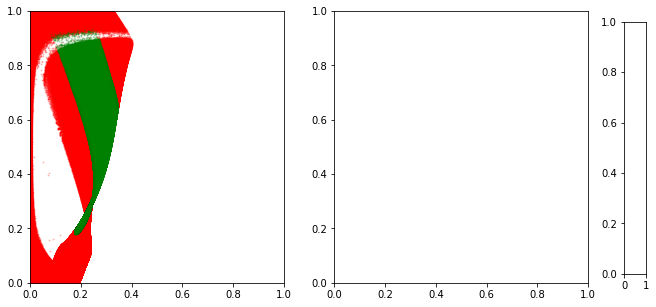

In [19]:
for i in [42]:
    sidebyside(i)

91


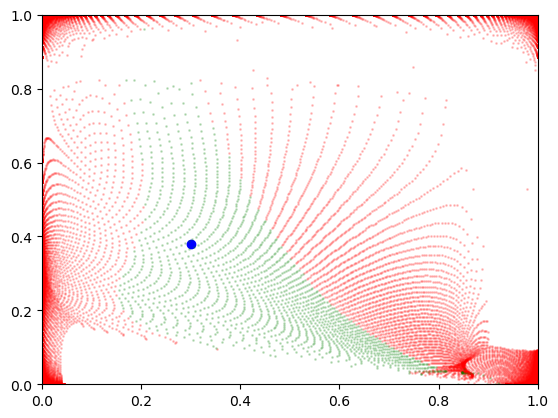

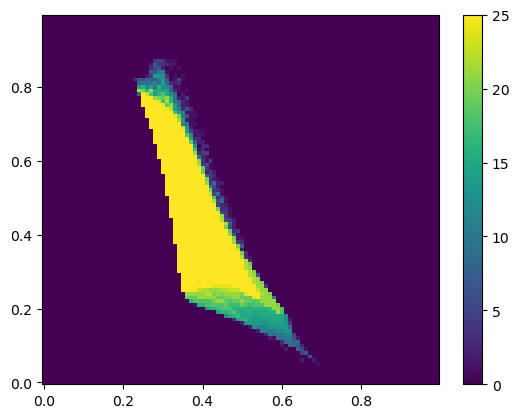

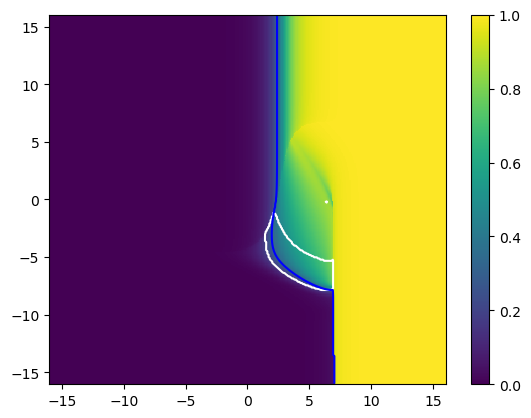

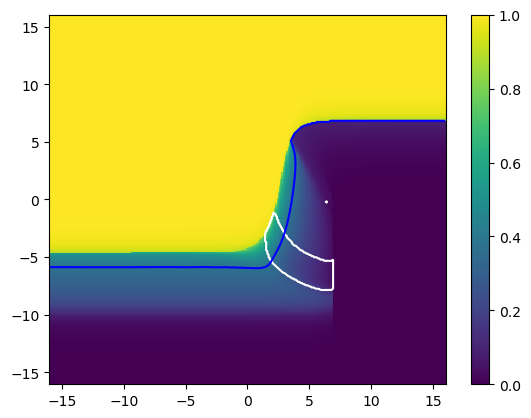

92


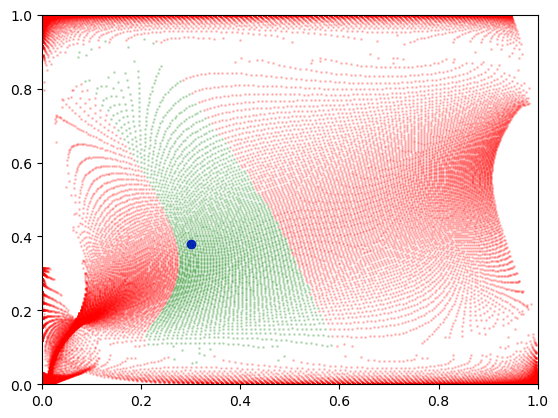

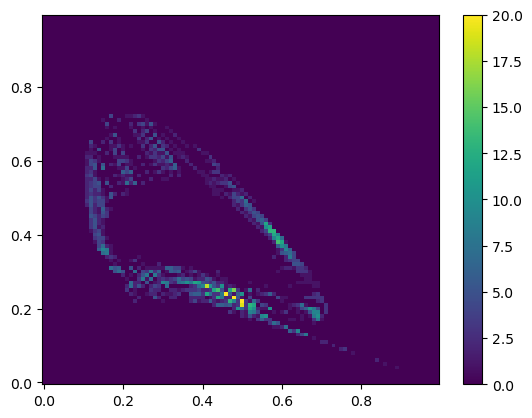

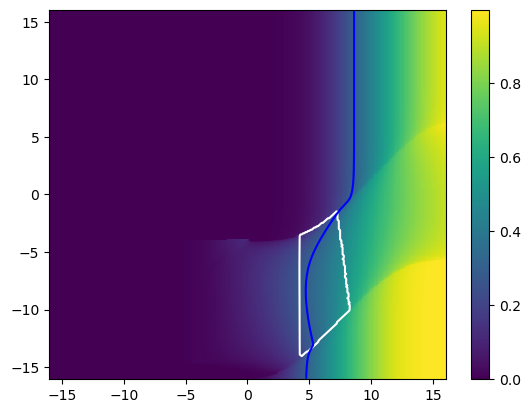

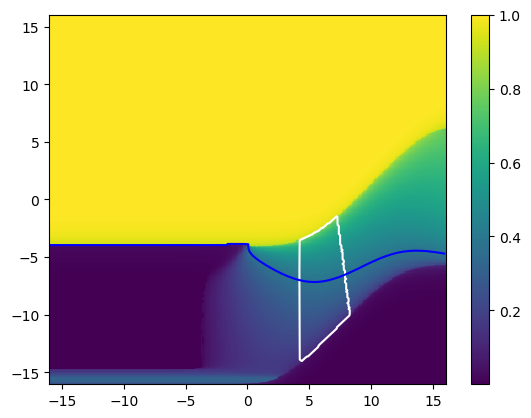

In [ ]:
# for i in unrealized_stricter:
for i in [91,92]:
    print(i)
    # plt.scatter(.3,.38,c='blue')
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    uniquevals(i,plot=True,ax=ax1)
    hpparslice = np.loadtxt('./Specifically Evolved HP Mechanisms/Every Circuit/%s/HPparslice_newrho_res5.dat'%i).T
    ax2.pcolormesh(metapar1res,metapar2res,hpparslice)
    ax3.colorbar(ax2)
    plt.show()
    avgs = get_avg_slice(i)
    plt.pcolormesh(par1res,par2res,avgs[:,:,0])
    plt.colorbar()
    plot_outline(i,'w')
    plt.contour(par1res,par2res,avgs[:,:,0],levels=[.3],colors=['blue'])
    plt.show()
    plt.pcolormesh(par1res,par2res,avgs[:,:,2])
    plt.colorbar()
    plot_outline(i,'w')
    plt.contour(par1res,par2res,avgs[:,:,2],levels=[.38],colors=['blue'])
    plt.show()

Once the HP parspace is updated for every circuit, print every circuit's:

- theoretical solvability at default threshold = 0.03
- best evolved recovery number (out of 121)
- best zero range recovery number (out of 25)

In [36]:
recovery = np.zeros((100,5,121,5))
final_recovery = np.zeros_like(recovery[:,:,:,0])
evolved_pyl_recovery = np.zeros((100,5))
zerorange_pyl_recovery = np.zeros((100))
for i in range(100):
    for j in range(5):
        # print(np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/%s/%s/recoverytest.dat"%(i,j))[:,2:])
        recovery[i,j] = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/%s/%s/recoverytest.dat"%(i,j))[:,2:]
        final_recovery[i,j] = recovery[i,j,:,-1]
        evolved_pyl_recovery[i,j] = np.sum(final_recovery[i,j]>=.3)
    hpparslice = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/HPparslice_newrho_res5.dat'%i).T
    zerorange_pyl_recovery[i] = np.max(hpparslice)


In [37]:
for i in range(100):
    print(i)
    solvability = uniquevals(i,evaluate=True,plot=False)
    print("Solvable: ", solvability)
    print("Evolved solutions: ", np.max(evolved_pyl_recovery[i]))
    print("Zero Range Solutions: ", zerorange_pyl_recovery[i])

0
True
Solvable:  True
Evolved solutions:  121.0
Zero Range Solutions:  25.0
1


KeyboardInterrupt: 

In [ ]:
for i in range(100):
    row_data = f"Row {i+1}\n"
        file.write(row_data)

In [108]:
#function to transform the averages point cloud into a more readable form
def avgs_density(indiv,gridsize):
    gridres = np.arange(0,1+gridsize,gridsize)
    plotgridres = gridres[:-1]
    densitygrid = np.zeros((len(gridres)-1,len(gridres)-1))
    pyloricslice = get_pyloric_slice(indiv)
    avgs = get_avg_slice(indiv)
    pyloricavgs = avgs[np.where(pyloricslice>=.3)][:,0::2]
    nonpyloricavgs = avgs[np.where(pyloricslice<.3)][:,0::2]

    for i in range(len(gridres)-1):
        for j in range(len(gridres)-1):
            pyloric_mask = (pyloricavgs[:,0]>=gridres[i])&(pyloricavgs[:,0]<gridres[i+1])&(pyloricavgs[:,1]>=gridres[j])&(pyloricavgs[:,1]<gridres[j+1])
            nonpyloric_mask = (nonpyloricavgs[:,0]>=gridres[i])&(nonpyloricavgs[:,0]<gridres[i+1])&(nonpyloricavgs[:,1]>=gridres[j])&(nonpyloricavgs[:,1]<gridres[j+1])
            if len(np.where(nonpyloric_mask)[0])>0:
                if len(np.where(pyloric_mask)[0])>0:
                    densitygrid[i,j] = 1
                else:
                    densitygrid[i,j] = .5
            elif len(np.where(pyloric_mask)[0])>0:
                densitygrid[i,j] = 1.5
            else:
                densitygrid[i,j] = 0
    return plotgridres, densitygrid.T

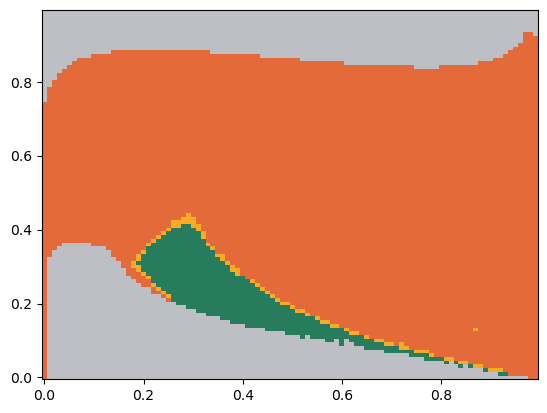

In [119]:
gridres,densitygrid = avgs_density(36,.01)
colormap = mcolors.ListedColormap([french_gray,flame,xanthous,viridian])
plt.pcolormesh(gridres,gridres,densitygrid,cmap=colormap)

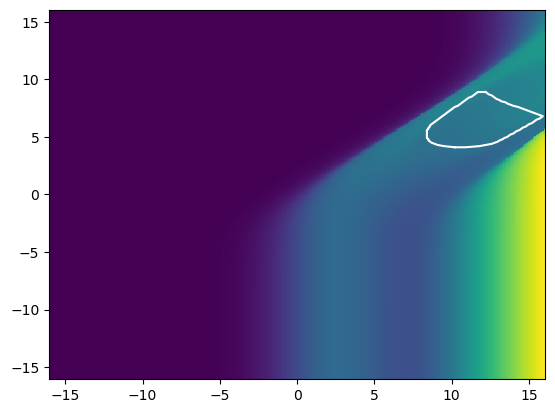

In [21]:
avgs = get_avg_slice(26)
plt.pcolormesh(par1res,par2res,avgs[:,:,0])
plot_outline(26,'white',False)

In [24]:
plot_HP_contours(26,.3,.3,[0],'w')

OSError: ./Specifically Evolved HP mechanisms/Every Circuit/26/HPAgnosticAverage_highres_newrho.dat not found.

Ask whether there is any value in the pyloric region which is "stable" (approached in the correct way from both dimensions)

In [252]:
[par1s,par2s] =np.where(pyloricslice>=.3)
paridxs = np.dstack((par1s,par2s))
print(paridxs)

[[[  0 199]
  [  0 200]
  [  0 201]
  ...
  [ 38 198]
  [ 38 199]
  [ 39 195]]]


In [330]:
def find_nullcline(indiv,LB1,LB3,UB1,UB3,tolerance = 0.001):
    avgs = get_avg_slice(indiv)
    # pyloricslice = get_pyloric_slice(indiv)
    N1_nullcline = []
    N3_nullcline = []
    for i in range(len(par1res)):
        for j in range(len(par2res)):
            if (avgs[i,j,0]+tolerance>LB1 and avgs[i,j,0]+tolerance<UB1) or (avgs[i,j,0]-tolerance>LB1 and avgs[i,j,0]-tolerance<UB1):
                N1_nullcline.append([par2res[j],par1res[i]])
            if (avgs[i,j,2]+tolerance>LB3) and (avgs[i,j,2]-tolerance<UB3):
                N3_nullcline.append([par2res[j],par1res[i]])
    return N1_nullcline,N3_nullcline

In [1084]:
def rho(val,LB,UB):
    rho = np.piecewise(val,[val<LB,val>UB],[lambda val:(LB-val)/LB,lambda val:(UB-val)/(1-UB),0])
    return rho

def newrho(val,LB,UB):
    rho = np.piecewise(val,[val<LB,val>UB],[lambda val:-val+LB,lambda val:-val+UB,0])
    return rho

In [797]:
avgs = get_avg_slice(19,True)
LB1 = 0.17125
LB3 = 0.355329
UB1 = 0.17125+0.0261298
UB3 = 0.355329

PeteB1 = 2.68606
PeteB3 = -8.09309

rho_1_avg = rho(avgs[:,:,0],LB1,UB1)
rho_3_avg = rho(avgs[:,:,2],LB3,UB3)
# for i in range(len(avgs)):
#     for j in range(len(avgs[0])):
#         rho_1_avg[i,j] = rho(avgs[i,j,0],LB1,UB1)
#         rho_3_avg[i,j] = rho(avgs[i,j,2],LB3,UB3)

plt.pcolormesh(par1res,par2res,rho_1_avg,cmap='bwr')
plot_outline(19,'black')
plt.colorbar()
plt.scatter(PeteB1,PeteB3,color='k')
plt.show()
plt.pcolormesh(par1res,par2res,rho_3_avg,cmap='bwr')
plt.colorbar()
plt.scatter(PeteB1,PeteB3,color='k')
plot_outline(19,'black')
plt.show()

ValueError: cannot reshape array of size 309123 into shape (600,600,3)

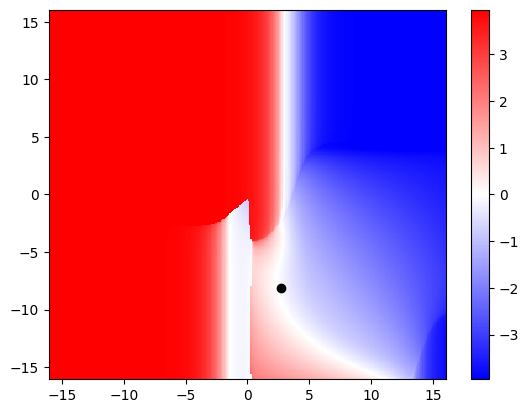

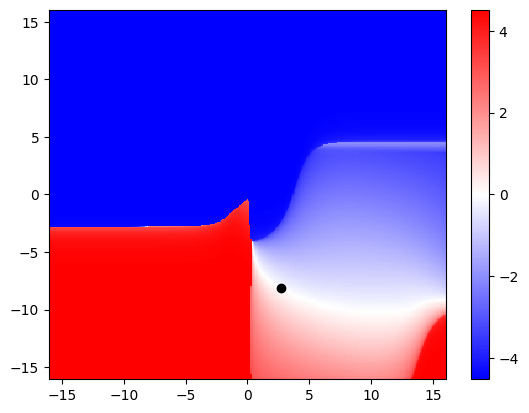

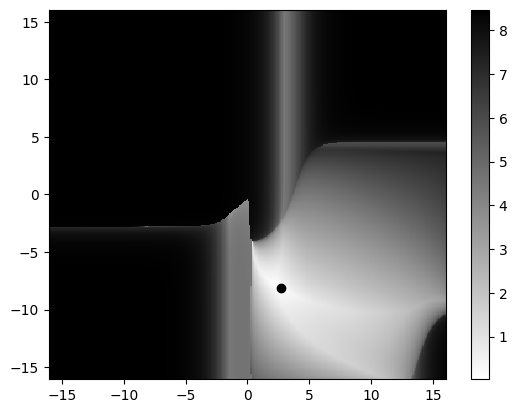

In [ ]:
#compare to the actual HP-directed change
change = np.loadtxt('./Petenetchangex33.dat')
change = change.reshape((len(par1res),len(par2res),2))
change = np.swapaxes(change,1,0)

plt.pcolormesh(par1res,par2res,change[:,:,0],cmap='bwr')
plt.colorbar()
plt.scatter(PeteB1,PeteB3,color='k')
plt.show()
plt.pcolormesh(par1res,par2res,change[:,:,1],cmap='bwr')
plt.colorbar()
plt.scatter(PeteB1,PeteB3,color='k')
plt.show()
plt.pcolormesh(par1res,par2res,np.abs(change[:,:,0])+np.abs(change[:,:,1]),cmap='binary')
plt.colorbar()
plt.scatter(PeteB1,PeteB3,color='k')
plt.show()

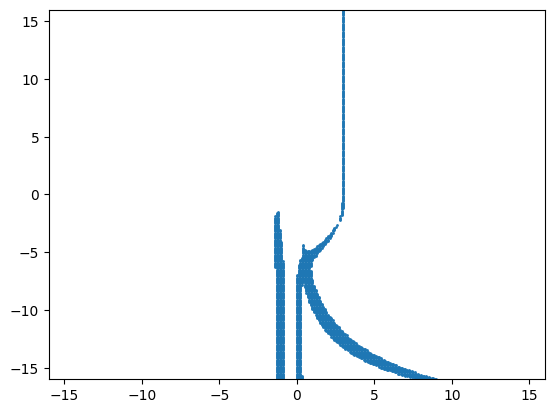

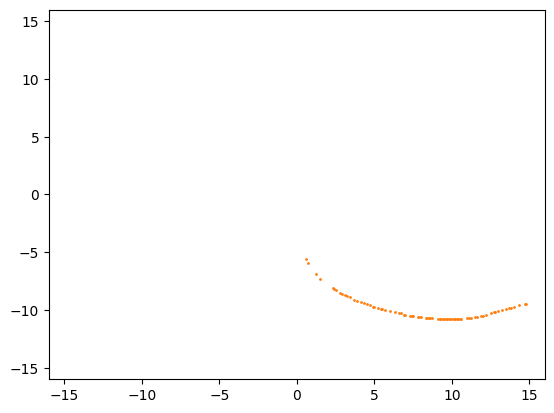

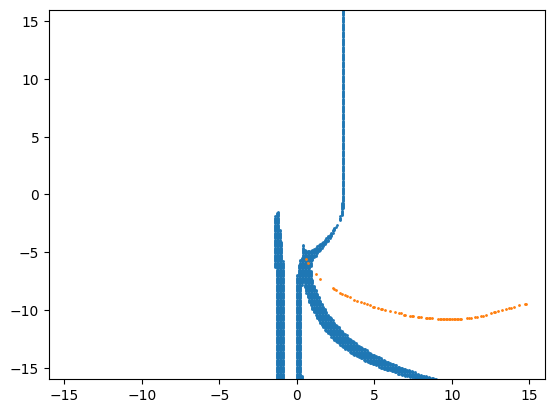

In [332]:
[n1_nullcline,n3_nullcline] = find_nullcline(19,0.17125, 0.355329, 0.17125+0.0261298, 0.355329,tolerance = 0.001)
n1_nullcline = np.array(n1_nullcline)
n3_nullcline = np.array(n3_nullcline)
plt.scatter(n1_nullcline[:,0],n1_nullcline[:,1],s=1)
plt.xlim((-16,16))
plt.ylim((-16,16))
plt.show()
plt.scatter(n3_nullcline[:,0],n3_nullcline[:,1],s=1,color='tab:orange')
plt.xlim((-16,16))
plt.ylim((-16,16))
plt.show()
plt.scatter(n1_nullcline[:,0],n1_nullcline[:,1],s=1,color='tab:blue')
plt.scatter(n3_nullcline[:,0],n3_nullcline[:,1],s=1,color='tab:orange')
plt.ylim((-16,16))
plt.xlim((-16,16))
plt.show()

In [293]:
def stable_existence(indiv, LB1,UB1,LB3,UB3):
    avgs = get_avg_slice(indiv)
    pyloricslice = get_pyloric_slice(indiv)
    [par1s,par2s] =np.where(pyloricslice>=.3)
    paridxs = np.dstack((par1s,par2s))[0]
    stable_point_existence = False
    stable_point_example = np.zeros(2)
    for point in paridxs:
        par1stability = False
        par2stability = False
        #is it stable from the left or from the right
        if ((point[0]>0) and (avgs[point[0]-1,point[1],0] < LB1) and (avgs[point[0],point[1],0] >= LB1)) or ((point[0]<len(par1res)) and (avgs[point[0]+1,point[1],0] > UB1) and (avgs[point[0],point[1],0] <= UB1)):
            par1stability = True
            stable_point_example[0] = par1res[point[0]]
        # and is it stable from above or below
        if ((point[1]>0) and (avgs[point[0],point[1]-1,2] < LB3) and (avgs[point[0],point[1],2] >= LB3)) or ((point[1]<len(par2res)) and (avgs[point[0],point[1]+1,2] > UB3) and (avgs[point[0],point[1],2] <= UB3)):
            par2stability = True
            stable_point_example[1] = par2res[point[1]]
        if(par1stability and par2stability):
            stable_point_existence = True
            break
    if stable_point_existence:
        return stable_point_existence, stable_point_example
    else: 
        return stable_point_existence

In [295]:
#this function does not search all possible HP values for a stable point, but
#provides information specific to a set of HP values
stable_existence(19,0.130271, 0.235268 ,0.130271+0.0902739, 0.235268+ 0.0642635)

False

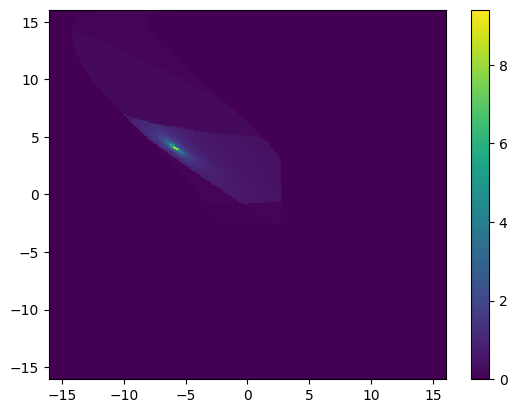

In [465]:
slice = get_pyloric_slice(82)
plt.pcolormesh(par1res,par2res,slice)
plt.colorbar()
plt.show()

Specific unsolvable example from individual 18

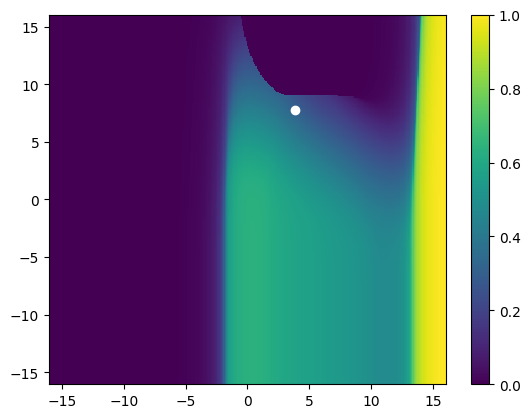

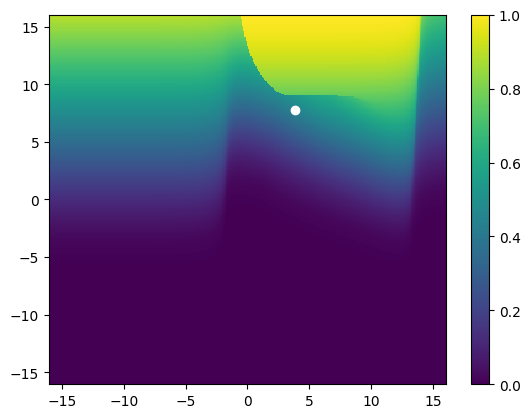

In [62]:
avgs = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/18/HPAgnosticAverage.dat")
avgs = avgs.reshape((len(par1res),len(par2res),3))
avgs = np.swapaxes(avgs,1,0)
circuitB1 = 3.87673
circuitB3 = 7.72929
plt.pcolormesh(par1res,par2res,avgs[:,:,0])
plt.scatter(circuitB1,circuitB3,color='white')
plt.colorbar()
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2])
plt.scatter(circuitB1,circuitB3,color='white')
plt.colorbar()
plt.show()

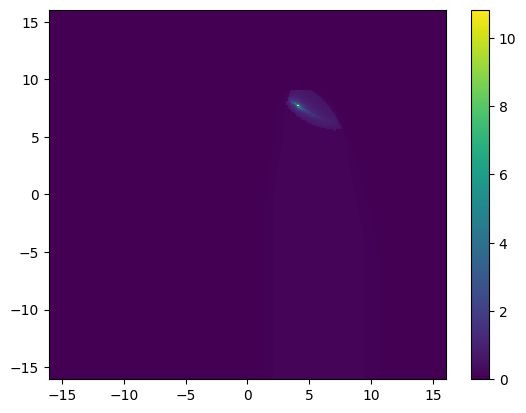

In [63]:
pyloricslice = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/18/pyloricslice.dat').reshape((len(par1res),len(par2res)))
pyloricslice = np.swapaxes(pyloricslice,1,0)
plt.pcolormesh(par1res,par2res,pyloricslice)
plt.colorbar()
plt.show()

In [64]:
maskingslice = np.repeat(pyloricslice,3,axis=1).reshape((len(pyloricslice),len(pyloricslice[0]),3))

In [65]:
pyloricavgs = np.ma.masked_where(maskingslice<0.3,avgs)
nonpyloricavgs = np.ma.masked_where(maskingslice>=0.3,avgs)

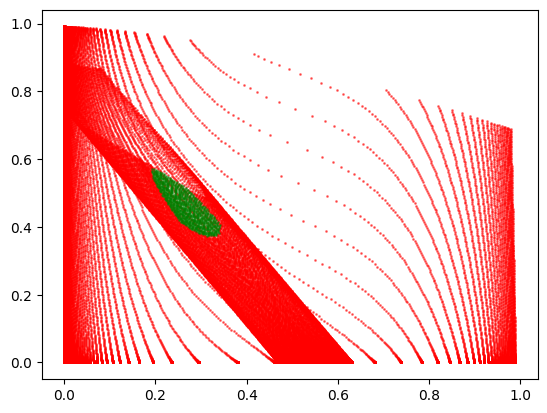

In [69]:
plt.scatter(nonpyloricavgs[:,:,0],nonpyloricavgs[:,:,2],color='red',alpha=.5,s=1)
plt.scatter(pyloricavgs[:,:,0],pyloricavgs[:,:,2],color='green',alpha=.5,s=1)

The above picture shows an unsolvable plane because the only combinations of pyloric averages also exist elsewhere. There is no unique combination of averages that would specify pyloricness. This is confirmed by inability to evolve a solution for individual 18

Specific solvable example from individual 19

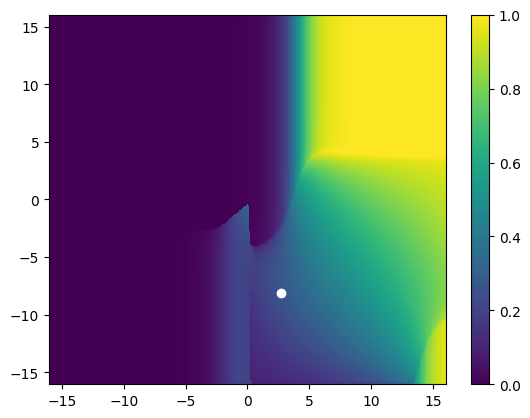

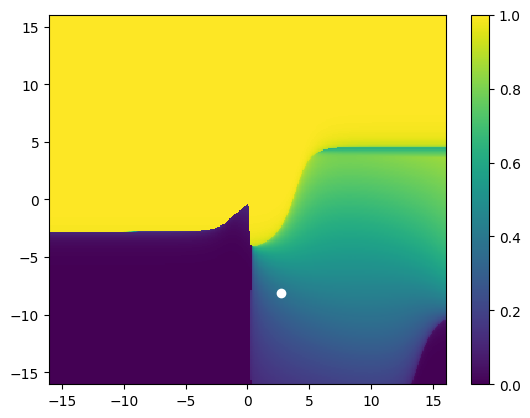

In [70]:
avgs = np.loadtxt("./Specifically Evolved HP mechanisms/Every Circuit/19/HPAgnosticAverage.dat")
avgs = avgs.reshape((len(par1res),len(par2res),3))
avgs = np.swapaxes(avgs,1,0)
circuitB1 = 2.68606
circuitB3 = -8.09309 
plt.pcolormesh(par1res,par2res,avgs[:,:,0])
plt.scatter(circuitB1,circuitB3,color='white')
plt.colorbar()
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2])
plt.scatter(circuitB1,circuitB3,color='white')
plt.colorbar()
plt.show()

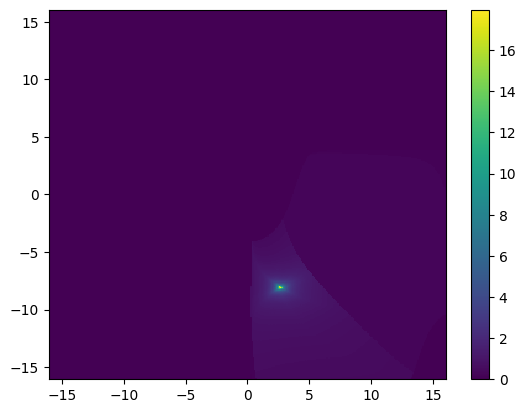

In [75]:
pyloricslice = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/19/pyloricslice.dat').reshape((len(par1res),len(par2res)))
pyloricslice = np.swapaxes(pyloricslice,1,0)
plt.pcolormesh(par1res,par2res,pyloricslice)
plt.colorbar()
plt.show()

In [76]:
maskingslice = np.repeat(pyloricslice,3,axis=1).reshape((len(pyloricslice),len(pyloricslice[0]),3))

In [77]:
pyloricavgs = np.ma.masked_where(maskingslice<0.3,avgs)
nonpyloricavgs = np.ma.masked_where(maskingslice>=0.3,avgs)

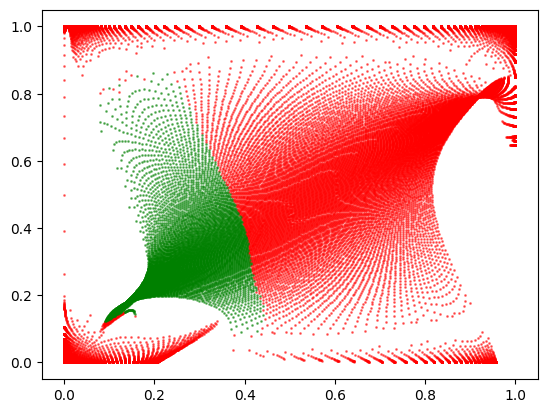

In [78]:
plt.scatter(nonpyloricavgs[:,:,0],nonpyloricavgs[:,:,2],color='red',alpha=.5,s=1)
plt.scatter(pyloricavgs[:,:,0],pyloricavgs[:,:,2],color='green',alpha=.5,s=1)

## Here is the Figure Formatting 

In [1127]:
#load in trajectories and choose indecies to use
dt = .005
dur = 20000+(2*dt)
time = np.arange(0,dur,dt)

good_Trajectories = np.loadtxt('./Convenient HP Mechanisms/good_biastrack.dat')

# good_Trajectories = np.loadtxt('./Convenient HP Mechanisms/good_biastrack.dat').reshape(len(time),2)
# bad_Trajectories = np.loadtxt('./Convenient HP Mechanisms/bad_biastrack.dat').reshape(len(time),2)

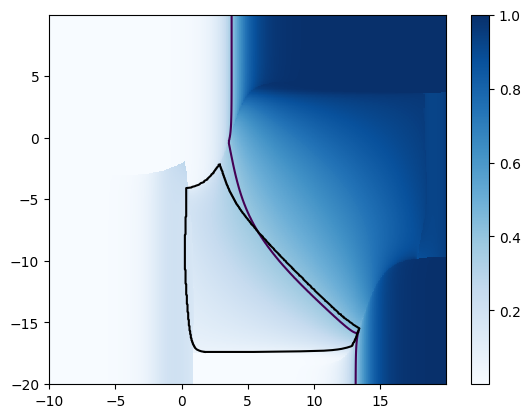

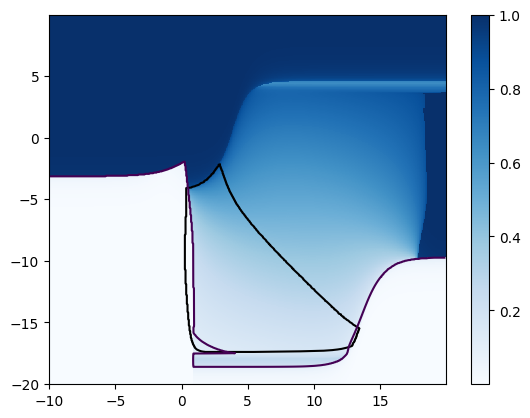

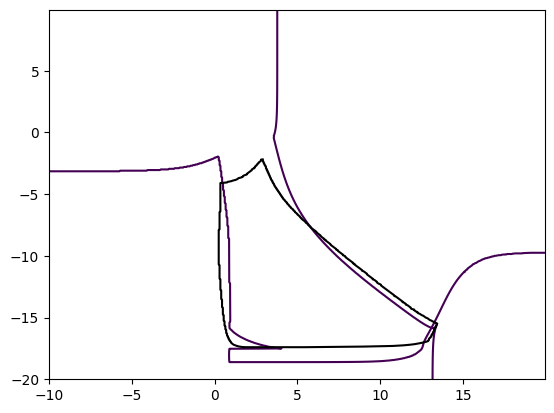

In [1128]:
avgs,multi = get_avg_slice(19,type = 'multistability_check')

# avgs_multi, multistability = get_avg_slice(19,type='multistability_check')

#determine whether defaulting to the lower initial condition is affecting the detected averages in an appreciable way...?
plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plt.colorbar()
plt.contour(par1res,par2res,avgs[:,:,0],levels=[0.386618])
plot_outline(19,'black',True)
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plt.colorbar()
plot_outline(19,'black',True)
plt.contour(par1res,par2res,avgs[:,:,2],levels=[0.128416])
plt.show()
plt.contour(par1res,par2res,avgs[:,:,0],levels=[0.386618])
plt.contour(par1res,par2res,avgs[:,:,2],levels=[0.128416])
plot_outline(19,'black',True)
# plt.pcolormesh(par1res,par2res,avgs_multi[:,:,0])
# plt.show()
# plt.pcolormesh(par1res,par2res,avgs[:,:,0]-avgs_multi[:,:,0])
# plt.show()
# traj = np.loadtxt('./Convenient HP Mechanisms/good_biastrack.dat').reshape((repeats,len(time),2))
# plt.scatter(traj[0,-1,0],traj[0,-1,1])
# for i in range(repeats):
#     plt.plot(traj[i,:,0],traj[i,:,1],linewidth=1,color=french_gray)
plt.show()



ValueError: cannot reshape array of size 103041 into shape (600,600)

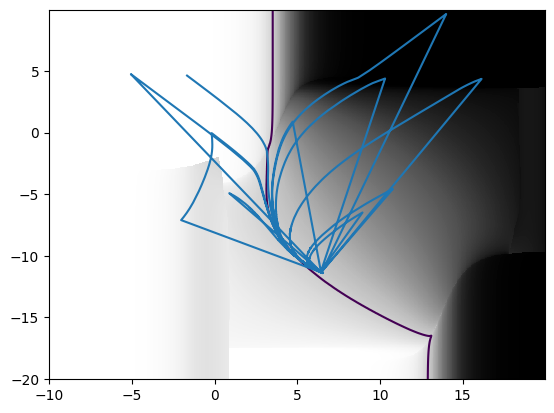

In [1129]:

# good_Trajectories = np.loadtxt('./Convenient HP Mechanisms/good_biastrack.dat').reshape(len(time),2)

PeteB1 = 2.68606
PeteB3 = -8.09309

plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Greys")
plt.contour(par1res,par2res,avgs[:,:,0],levels=[.3])
# plot_nullcline('par1',.17125,avgs,viridian)
plt.plot(good_Trajectories[:,0],good_Trajectories[:,1])
plot_outline(19,"r",False)
plt.scatter([PeteB1],[PeteB3],color='k')
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Greys")
plt.contour(par1res,par2res,avgs[:,:,2],levels=[.3])
plt.plot(good_Trajectories[:,0],good_Trajectories[:,1])
plot_outline(19,"r",False)
plt.show()

plt.contour(par1res,par2res,avgs[:,:,0],levels=[.3])
plt.contour(par1res,par2res,avgs[:,:,2],levels=[.3])
plt.show()

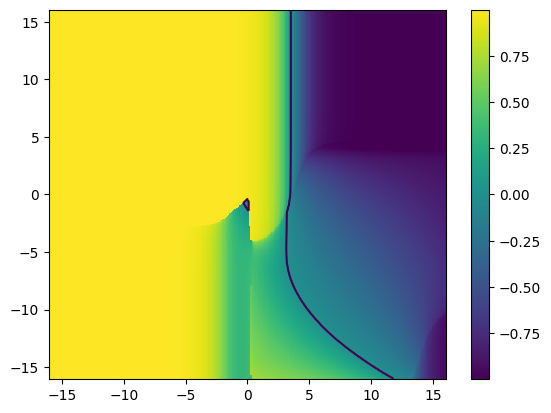

In [ ]:
# print(avgs[:,:,0])
test = rho(avgs[:,:,0],.3,.3)
plt.pcolormesh(par1res,par2res,test)
plt.colorbar()
plt.contour(par1res,par2res,test,levels=[0])

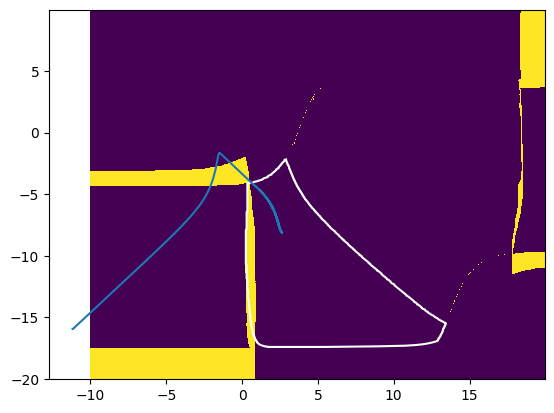

In [ ]:
#there's a serious problem here let's check the multistability

plt.pcolormesh(par1res,par2res,multistability)
plot_outline(19,'w',True)
plt.plot(good_Trajectories[:,0],good_Trajectories[:,1])

In [836]:
#get the new data

avgs = np.zeros((len(par1res),len(par2res),3))

for i in range(600):
    bar = np.loadtxt("./CompareHPagnostic%s.dat"%i).reshape((len(par2res),2))
    avgs[:,i,::2] = bar
    avgs.swapaxes(0,1)



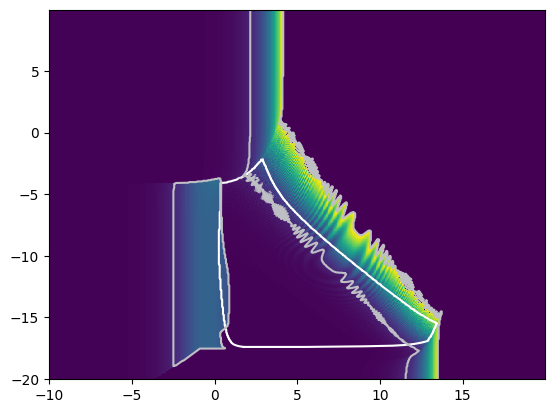

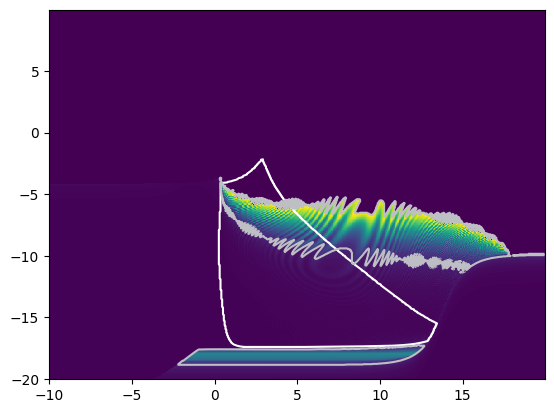

In [838]:
plt.pcolormesh(par1res,par2res,avgs[:,:,0])
plot_outline(19,'white',True)
plt.contour(par1res,par2res,avgs[:,:,0],levels=[.1],colors=french_gray)
# plot_nullcline('par1',.2,avgs,color='white')
plt.show()
plt.pcolormesh(par1res,par2res,avgs[:,:,2])
plot_outline(19,'white',True)
plt.contour(par1res,par2res,avgs[:,:,2],levels=[.1],colors=french_gray)
plt.show()

[ 12.9629 -14.6107] [ 12.9629 -14.6107]


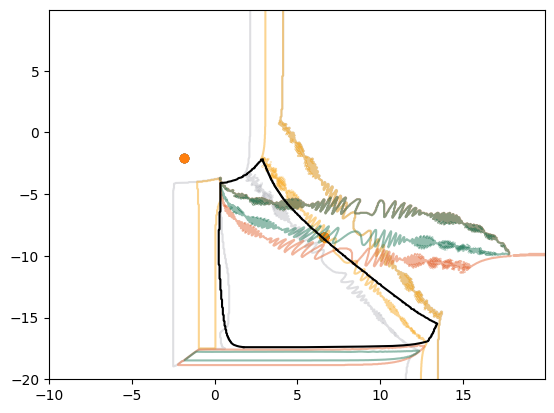

In [ ]:
level = [[.1,.3],[.1,.3]]
dur = 20000
dt = 0.05
time = np.arange(0,dur+dt,dt)
repeats = 10
traj = np.loadtxt('./Convenient HP Mechanisms/good_biastrack.dat').reshape((repeats,len(time),2))
print(traj[0,0],traj[0,1])
plt.contour(par1res,par2res,avgs[:,:,0],levels=level[0],colors=[french_gray,xanthous],alpha=.5)
plt.contour(par1res,par2res,avgs[:,:,2],levels=level[1],colors=[flame,viridian],alpha=.5)
# for i in range(repeats):
    # plt.plot(traj[i,:,0],traj[i,:,1])
plt.scatter(traj[:,-1,0],traj[:,-1,1])
plt.scatter(traj[:,-1,0],traj[:,-1,1])
plot_outline(19,'black',True)
plt.show()

In [38]:
dur = 100000
dt = 0.05
time = np.arange(0,dur+dt,dt)
repeats = int(1000/50)
trackinterval = 5

In [40]:
trajgood = np.loadtxt('./Convenient HP Mechanisms/Petebiastrackgood.dat').reshape((repeats,int(len(time)/trackinterval),2))
trajmixed = np.loadtxt('./Convenient HP Mechanisms/Petebiastrackmixed.dat').reshape((repeats,int(len(time)/trackinterval),2))
trajbad = np.loadtxt('./Convenient HP Mechanisms/Petebiastrackbad.dat').reshape((repeats,int(len(time)/trackinterval),2))

In [43]:
for i in range(len(trajmixed)):
    print(trajmixed[i,-1,:])

[  6.08994 -15.3264 ]
[  4.563 -14.695]
[-0.596643 -4.26107 ]
[-0.814819 -3.29162 ]
[  6.19106 -15.3609 ]
[  4.69682 -14.7597 ]
[-1.1998  -1.54406]
[-0.80573 -3.30475]
[  4.63479 -14.7309 ]
[  6.19454 -15.3619 ]
[  4.73586 -14.7768 ]
[-0.740501 -3.63665 ]
[  5.14328 -14.9627 ]
[  4.65388 -14.7403 ]
[  6.24288 -15.3783 ]
[  4.64206 -14.7306 ]
[  4.64339 -14.7352 ]
[  4.89544 -14.8534 ]
[-0.877261 -2.99131 ]
[  6.19596 -15.3631 ]


[0.17     0.257165 0.5     ]
[-15.1176     9.44068    5.43897  -15.7016   -18.3246     0.350228
 -16.437     -4.47414    6.50992  -18.1514     1.48646   -1.46615
  -9.43282    0.169592 -18.1969     9.7138     3.63349   -5.1977
   8.66728  -18.4593  ]


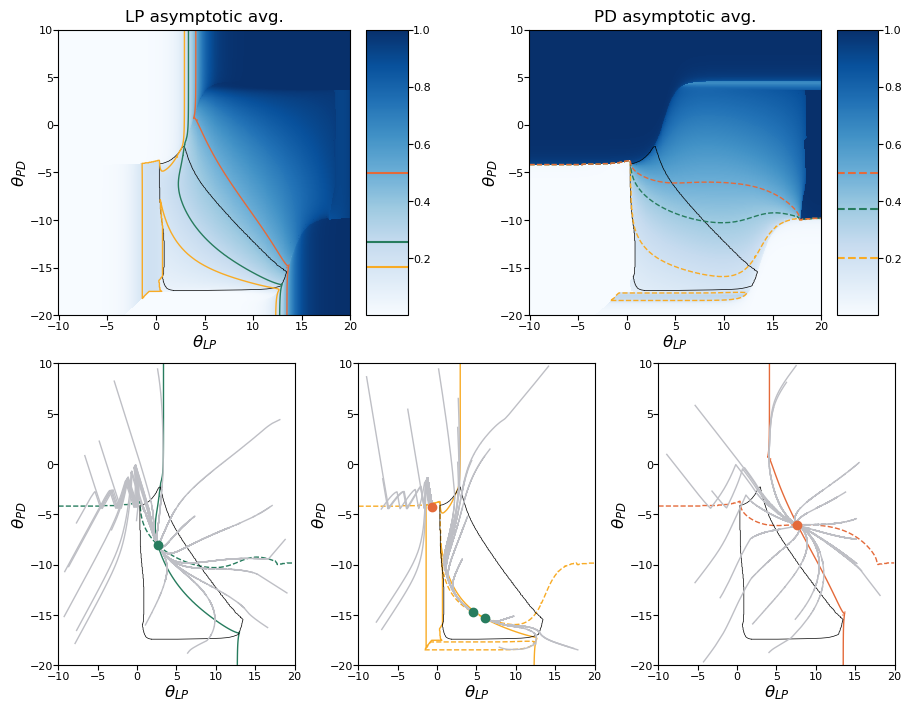

In [46]:
avgs,dutycycles = get_avg_slice(19,type='newrho')

good_targets = [0.257165,0.371159]
bad_targets = [.5,.5]
mixed_targets = [.17,.2]
all_targets = np.array([mixed_targets,good_targets,bad_targets])
print(all_targets[:,0])

upper_arr = [['a','a','a','a','a','a','a','colorbar1','.','b','b','b','b','b','b','b','colorbar2']]
lower_arr = [['c','d','e']]
arrangementstring = [[upper_arr],[lower_arr]]
fig, axd = plt.subplot_mosaic(arrangementstring,figsize=(9, 7), layout="constrained",gridspec_kw={"hspace":5})

ax1,colorbarax1,ax2,colorbarax2,ax3,ax4,ax5 = fig.get_axes()

#LP mesh and nullclines
mesh1= ax1.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
plot_outline(19,'black',True,ax=ax1)
cbar1 = fig.colorbar(mesh1,cax=colorbarax1, ax=[ax1])
contour1 = ax1.contour(par1res,par2res,avgs[:,:,0],levels=all_targets[:,0],colors=[xanthous,viridian,flame],linewidths=1)
cbar1.ax.hlines(all_targets[:,0],0,1,colors=[xanthous,viridian,flame])
cbar1.ax.tick_params(labelsize=8,pad=.5)
ax1.set_title('LP asymptotic avg.')

#PD mesh and nullclines
mesh2=ax2.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
plot_outline(19,'black',True,ax=ax2)
cbar2 = fig.colorbar(mesh2,cax=colorbarax2, ax=[ax2])
contour2 = ax2.contour(par1res,par2res,avgs[:,:,2],levels=all_targets[:,1],colors=[xanthous,viridian,flame],linestyles='dashed',linewidths=1)
cbar2.ax.hlines(all_targets[:,1],0,1,colors=[xanthous,viridian,flame],linestyles='dashed')
cbar2.ax.tick_params(labelsize=8,pad=.5)
ax2.set_title('PD asymptotic avg.')

#good HP nullclines and trajectories
contour3n1 = ax3.contour(par1res,par2res,avgs[:,:,0],levels=[good_targets[0]],colors=viridian,linewidths=1)
contour3n3 = ax3.contour(par1res,par2res,avgs[:,:,2],levels=[good_targets[1]],colors=viridian,linewidths=1,linestyles='dashed')
plot_outline(19,'black',True,ax=ax3)
ax3.scatter(trajgood[0,-1,0],trajgood[0,-1,1],color=viridian,zorder=3)
for i in range(repeats):
    ax3.plot(trajgood[i,:,0],trajgood[i,:,1],linewidth=1,color=french_gray)

#mixed HP nullclines and trajectories
contour4n1 = ax4.contour(par1res,par2res,avgs[:,:,0],levels=[mixed_targets[0]],colors=xanthous,linewidths=1)
contour4n3 = ax4.contour(par1res,par2res,avgs[:,:,2],levels=[mixed_targets[1]],colors=xanthous,linewidths=1,linestyles='dashed')
plot_outline(19,'black',True,ax=ax4)
print(trajmixed[:,0,1])
ax4.scatter(trajmixed[0,-1,0],trajmixed[0,-1,1],color=viridian,zorder=3)
ax4.scatter(trajmixed[1,-1,0],trajmixed[1,-1,1],color=viridian,zorder=3)
ax4.scatter(trajmixed[2,-1,0],trajmixed[2,-1,1],color=flame,zorder=3)
for i in range(repeats):
    ax4.plot(trajmixed[i,:,0],trajmixed[i,:,1],linewidth=1,color=french_gray)

#bad HP nullclines and trajectories
contour5n1 = ax5.contour(par1res,par2res,avgs[:,:,0],levels=[bad_targets[0]],colors=flame,linewidths=1)
contour5n3 = ax5.contour(par1res,par2res,avgs[:,:,2],levels=[bad_targets[1]],colors=flame,linewidths=1,linestyles='dashed')
plot_outline(19,'black',True,ax=ax5)
ax5.scatter(trajbad[0,-1,0],trajbad[0,-1,1],color=flame,zorder=3)
for i in range(repeats):
    ax5.plot(trajbad[i,:,0],trajbad[i,:,1],linewidth=1,color=french_gray)

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xticks([-10,-5,0,5,10,15,20])
    ax.set_yticks([-20,-15,-10,-5,0,5,10])
    ax.tick_params(labelsize=8,pad=.5)
    ax.set_xlabel(r'$\theta_{LP}$',labelpad=1,fontsize=12)
    ax.set_ylabel(r'$\theta_{PD}$',labelpad=.5,fontsize=12)
plt.show()

OSError: ./Convenient HP Mechanisms/good_biastrack.dat not found.

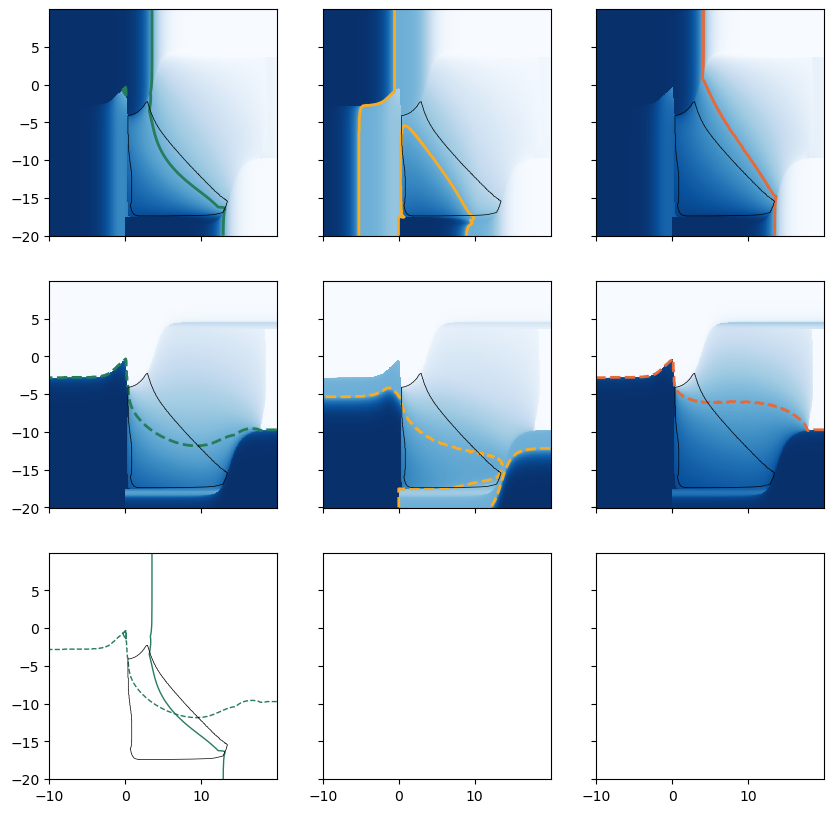

In [ ]:
#reattempt with the 3x3 grid


good_targets = [.3,.3]
bad_targets = [.5,.5]
mixed_targets = [.005,.005]
all_targets = np.array([mixed_targets,good_targets,bad_targets])

fig, axs = plt.subplots(3,3,sharex=True,sharey=True,figsize=(10,10))

#good HP N1 push
goodavgs = np.loadtxt("./Convenient HP Mechanisms/goodnetchange2.dat").reshape(len(par2res),len(par1res),2)
goodavgs = goodavgs.swapaxes(1,0)
axs[0,0].pcolormesh(par1res,par2res,goodavgs[:,:,0],cmap="Blues")
axs[0,0].contour(par1res,par2res,goodavgs[:,:,0],levels=0,colors=viridian,linewidths=2)
plot_outline(19,'black',True,ax=axs[0,0])

#good HP N3push
axs[1,0].pcolormesh(par1res,par2res,goodavgs[:,:,1],cmap="Blues")
axs[1,0].contour(par1res,par2res,goodavgs[:,:,1],levels=0,colors=viridian,linewidths=2,linestyles='dashed')
plot_outline(19,'black',True,ax=axs[1,0])

#mixed HP N1push
mixedavgs = np.loadtxt("./Convenient HP Mechanisms/mixednetchange.dat").reshape(len(par2res),len(par1res),2)
mixedavgs = mixedavgs.swapaxes(1,0)
axs[0,1].pcolormesh(par1res,par2res,mixedavgs[:,:,0],cmap="Blues")
axs[0,1].contour(par1res,par2res,mixedavgs[:,:,0],levels=0,colors=xanthous,linewidths=2)
plot_outline(19,'black',True,ax=axs[0,1])

#mixed HP N3push
axs[1,1].pcolormesh(par1res,par2res,mixedavgs[:,:,1],cmap="Blues")
axs[1,1].contour(par1res,par2res,mixedavgs[:,:,1],levels=0,colors=xanthous,linewidths=2,linestyles='dashed')
plot_outline(19,'black',True,ax=axs[1,1])

#bad HP N1push
badavgs = np.loadtxt("./Convenient HP Mechanisms/badnetchange.dat").reshape(len(par2res),len(par1res),2)
badavgs = badavgs.swapaxes(1,0)
axs[0,2].pcolormesh(par1res,par2res,badavgs[:,:,0],cmap="Blues")
axs[0,2].contour(par1res,par2res,badavgs[:,:,0],levels=0,colors=flame,linewidths=2)
plot_outline(19,'black',True,ax=axs[0,2])

#bad HP n3push
axs[1,2].pcolormesh(par1res,par2res,badavgs[:,:,1],cmap="Blues")
axs[1,2].contour(par1res,par2res,badavgs[:,:,1],levels=0,colors=flame,linestyles = 'dashed',linewidths=2)
plot_outline(19,'black',True,ax=axs[1,2])

#good HP nullclines and trajectories
# contour3n1 = axs[2,0].contour(par1res,par2res,avgs[:,:,0],levels=[good_targets[0]],colors=viridian,linewidths=1)
# contour3n3 = axs[2,0].contour(par1res,par2res,avgs[:,:,2],levels=[good_targets[1]],colors=viridian,linewidths=1,linestyles='dashed')
axs[2,0].contour(par1res,par2res,goodavgs[:,:,0],levels=0,colors=viridian,linewidths=1)
axs[2,0].contour(par1res,par2res,goodavgs[:,:,1],levels=0,colors=viridian,linewidths=1,linestyles='dashed')
plot_outline(19,'black',True,ax=axs[2,0])
traj = np.loadtxt('./Convenient HP Mechanisms/good_biastrack.dat').reshape((repeats,len(time),2))
print(traj[6,-1,0],traj[6,-1,1])
axs[2,0].scatter(traj[1,-1,0],traj[1,-1,1],color=viridian,zorder=3)
for i in range(repeats):
    axs[2,0].plot(traj[i,:,0],traj[i,:,1],linewidth=1,color=french_gray)

#mixed HP nullclines and trajectories
# contour4n1 = axs[2,1].contour(par1res,par2res,avgs[:,:,0],levels=[mixed_targets[0]],colors=xanthous,linewidths=1)
# contour4n3 = axs[2,1].contour(par1res,par2res,avgs[:,:,2],levels=[mixed_targets[1]],colors=xanthous,linewidths=1,linestyles='dashed')
plot_outline(19,'black',True,ax=axs[2,1])
traj = np.loadtxt('./Convenient HP Mechanisms/mixed_biastrack.dat').reshape((repeats,len(time),2))
print(traj[:,0,0])
axs[2,1].contour(par1res,par2res,mixedavgs[:,:,0],levels=0,colors=xanthous,linewidths=1)
axs[2,1].contour(par1res,par2res,mixedavgs[:,:,1],levels=0,colors=xanthous,linewidths=1,linestyles='dashed')
axs[2,1].scatter(traj[0,-1,0]-.7,traj[0,-1,1]-.5,color=flame,zorder=3)
axs[2,1].scatter(traj[7,-1,0],traj[7,-1,1],color=viridian,zorder=3)
print(traj[7,-1,0],traj[7,-1,1])
for i in range(repeats):
    axs[2,1].plot(traj[i,:,0],traj[i,:,1],linewidth=1,color=french_gray)

#bad HP nullclines and trajectories
# contour5n1 = axs[2,2].contour(par1res,par2res,avgs[:,:,0],levels=[bad_targets[0]],colors=flame,linewidths=1)
# contour5n3 = axs[2,2].contour(par1res,par2res,avgs[:,:,2],levels=[bad_targets[1]],colors=flame,linewidths=1,linestyles='dashed')
plot_outline(19,'black',True,ax=axs[2,2])
traj = np.loadtxt('./Convenient HP Mechanisms/bad_biastrack.dat').reshape((repeats,len(time),2))
axs[2,2].scatter(traj[0,-1,0],traj[0,-1,1],color=flame,zorder=3)
print(traj[6,-1,0],traj[6,-1,1])
for i in range(repeats):
    axs[2,2].plot(traj[i,:,0],traj[i,:,1],linewidth=1,color=french_gray)
axs[2,2].contour(par1res,par2res,badavgs[:,:,0],levels=0,colors=flame,linewidths=1)
axs[2,2].contour(par1res,par2res,badavgs[:,:,1],levels=0,colors=flame,linewidths=1,linestyles = 'dashed')

axs[0,0].set_title('Tgt = .3, Avg. Window = 0s',size=12,pad=15)
axs[0,1].set_title('Tgt = .005, Avg. Window = 10s',size=12,pad=15)
axs[0,2].set_title('Tgt = .5, Avg. Window = 0s',size=12,pad=15)
axs[0,0].text(-20,-5.0,"LP asymptotic change", size=12, verticalalignment='center', horizontalalignment='left',rotation=90)
axs[1,0].text(-20,-5.0,"PD asymptotic change", size=12, verticalalignment='center', rotation=90)
axs[2,0].text(-20,-5.0,"Combined", size=12, verticalalignment='center', rotation=90)

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i,j].set_xticks([-10,-5,0,5,10,15,20])
        axs[i,j].set_yticks([-20,-15,-10,-5,0,5,10])
        axs[i,j].tick_params(labelsize=8,pad=.5)
        if i == 2:
            axs[i,j].set_xlabel(r'$\theta_{LP}$',labelpad=1,fontsize=10)
        if j == 0:
            axs[i,j].set_ylabel(r'$\theta_{PD}$',labelpad=.5,fontsize=10)
plt.show()

In [1103]:
#testing new measure:

limitcycle = np.loadtxt("./Convenient HP Mechanisms/nullbiastrack.dat").reshape((-1,3))
starts = np.loadtxt("./Convenient HP Mechanisms/nullstatestrack.dat")

In [1104]:
srt = int(starts[4]/dt)
end = int(starts[-1]/dt)

In [ ]:
x = np.arange(0,2*np.pi,.01)
limitcycle = (np.sin(x)+1)/2
limitcycle = np.repeat(limitcycle,2).reshape((-1,2))
# limitcycle.swapaxes(1,0)
print(limitcycle)
srt = 0
end = len(x)

[[0.5        0.5       ]
 [0.50499992 0.50499992]
 [0.50999933 0.50999933]
 ...
 [0.48840839 0.48840839]
 [0.49340754 0.49340754]
 [0.49840735 0.49840735]]


0.2912408928443478
-0.05419895073101447


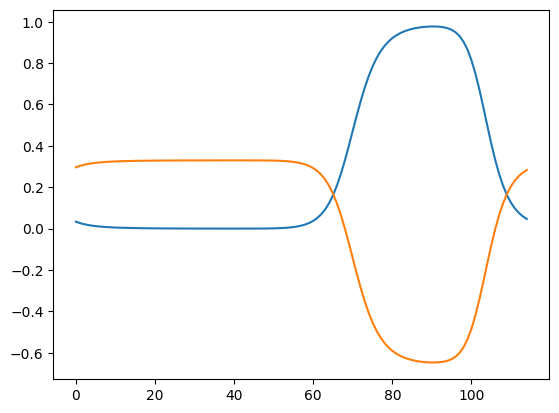

In [ ]:
plt.plot(limitcycle[srt:end,0])
target = .33
plt.plot(newrho(limitcycle[srt:end,0],target,target))
print(np.average(limitcycle[srt:end,0]))
print(np.average(newrho(limitcycle[srt:end],target,target)))


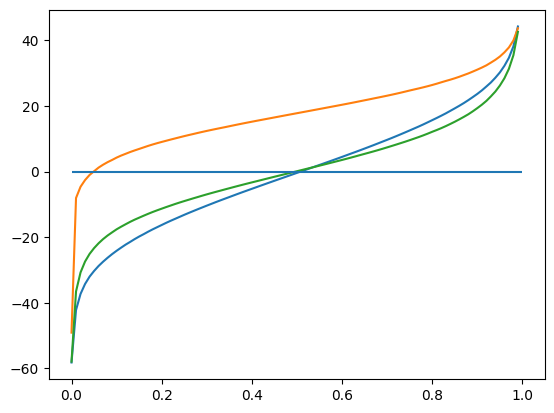

In [ ]:
bs = np.arange(0,1,.01)
test = np.zeros((len(bs),3))
for i in range(len(bs)):
    for j in range(3):
        test[i,j] = np.sum(rho(limitcycle[srt:end,j],bs[i],bs[i]))

plt.plot(bs,test)
plt.hlines(0,1,0)
plt.show()


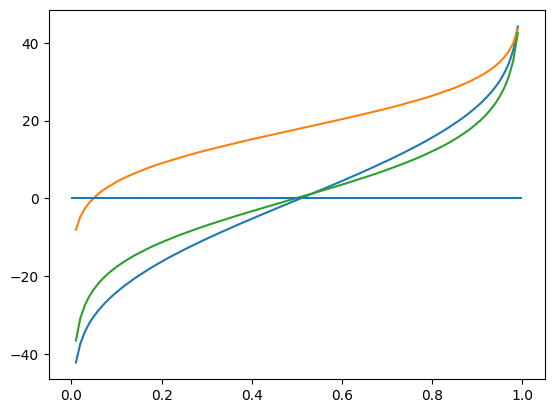

In [1080]:
bs = np.arange(0.01,1,.01)
test = np.zeros((len(bs),3))
for b in range(len(bs)):
    alpha = np.zeros(3)
    alphasteps = np.zeros(3)
    gamma = np.zeros(3)
    gammasteps = np.zeros(3)

    for i in range(srt,end):
        for j in range(3):
            if limitcycle[i,j] < bs[b]:
                alphasteps[j] += 1
                alpha[j] += limitcycle[i,j]
            else:
                gammasteps[j] +=1
                gamma[j] += limitcycle[i,j]
            test[b,j] = alphasteps[j] - (alpha[j]/bs[b]) + ((gammasteps[j]*bs[b])/(1-bs[b])) - (gamma[j]/(1-bs[b]))

plt.plot(bs,test)
plt.hlines(0,1,0)

[ 0.4666395   0.4732014   0.478296    0.482279    0.4854158   0.4879051
  0.4898959   0.49150044  0.49280381  0.4938708   0.49475109  0.49548298
  0.4960962   0.49661392  0.49705436  0.49743184  0.49775773  0.49804102
  0.49828886  0.4985069   0.49869964  0.49887057  0.49902242  0.49915732
  0.4992769   0.49938244  0.499475    0.49955552  0.49962489  0.49968405
  0.49973396  0.49977564  0.49981008  0.49983825  0.49986102  0.49987917
  0.49989332  0.49990392  0.49991126  0.4999154   0.49991607  0.49991256
  0.49990343  0.49988608  0.49985616  0.4998068   0.49972787  0.49960518
  0.49941928  0.49914382  0.4987432   0.49816955  0.49735861  0.49622443
  0.4946519   0.49248687  0.4895226   0.485482    0.4799943   0.472567
  0.4625547   0.449131    0.4312754   0.4077969   0.377421    0.338966
  0.291622    0.235288    0.170865    0.10038     0.026794   -0.046474
 -0.116175   -0.17978    -0.235758   -0.283569   -0.323452   -0.35614
 -0.382595   -0.403829   -0.420782   -0.434277   -0.444999   

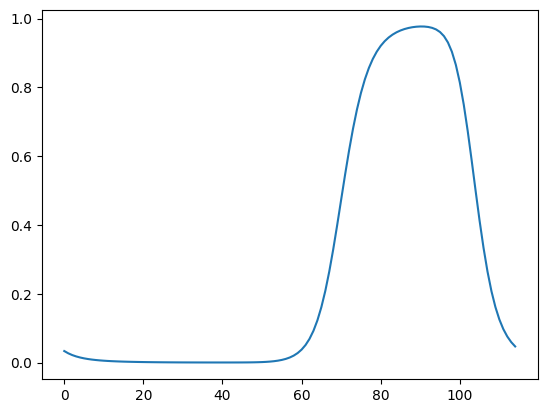

In [ ]:
plt.plot(limitcycle[srt:end,0])
print(newrho(limitcycle[srt:end,0],.5,.5))
print(np.sum(newrho(limitcycle[srt:end,0],.5,.5)))

In [1142]:
def solve_quadratic(a, b, c):
  """Solves a quadratic equation of the form ax^2 + bx + c = 0."""
  # Calculate the discriminant
  discriminant = b**2 - 4 * a * c

  # Find the two solutions
  x1 = (-b + np.sqrt(discriminant)) / (2 * a)
  x2 = (-b - np.sqrt(discriminant)) / (2 * a)

  return x1, x2


0.28695652173913044 0.29124089284434773
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436
0.08908555335330436


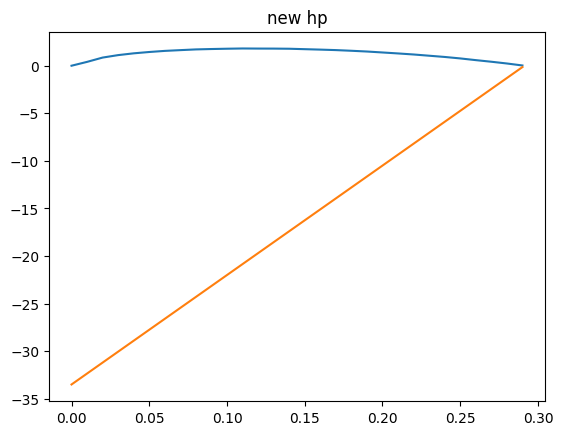

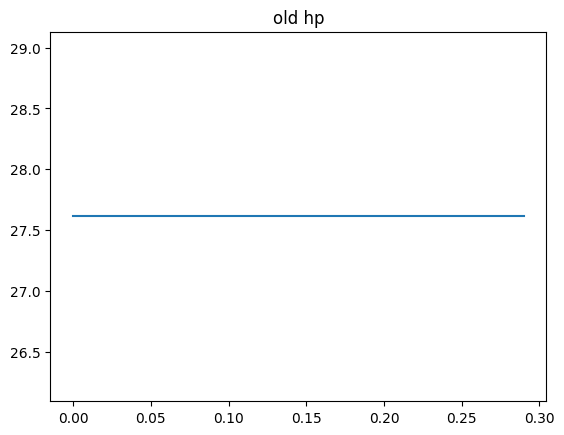

In [1146]:
#new HP
burst_dur = 0
avg_val = 0
for i in range(srt,end):
    if limitcycle[i,0] >= .5:
        burst_dur += 1
    avg_val += limitcycle[i,0]
period = end - srt
avg_val /= period
duty_cycle = burst_dur/period
print(duty_cycle,avg_val)

#old HP
xlow = 0
xhigh = 0
t = 0
h = 0
for i in range(srt,end):
    if limitcycle[i,0] >= .5:
        h += 1
        xhigh += limitcycle[i,0]
    else:
        t += 1
        xlow += limitcycle[i,0]

lbs = np.arange(0,avg_val,0.01)
testnewrho = np.zeros((len(lbs),2))
for i in range(len(lbs)):
    ubnew = (avg_val/duty_cycle)-((1-duty_cycle)*lbs[i]/duty_cycle)
    testnewrho[i,0] = np.sum(newrho(limitcycle[srt:end,0],lbs[i],ubnew))
    testnewrho[i,1] = np.sum(newrho(limitcycle[srt:end,0],lbs[i],lbs[i]))
bs = lbs
testoldrho = np.zeros(len(bs))
for i in range(len(bs)):
    lbold,x2 = solve_quadratic(h-t,t+xlow-xhigh,-xlow)
    print(lbold)
    testoldrho[i] = np.sum(rho(limitcycle[srt:end,0],lbold,lbold))
plt.plot(lbs,testnewrho)
plt.title('new hp')
plt.show()
plt.plot(bs,testoldrho)
plt.title('old hp')
plt.show()


So the assumptions I had are pretty good for the new, shifted rho, HP mechanism. Not so for the old, scaled HP mechanism. This leaves me with the option to redo evolutions for this new HP? Or alternatively just test if it is a good predictor

(0.0, 16.0)

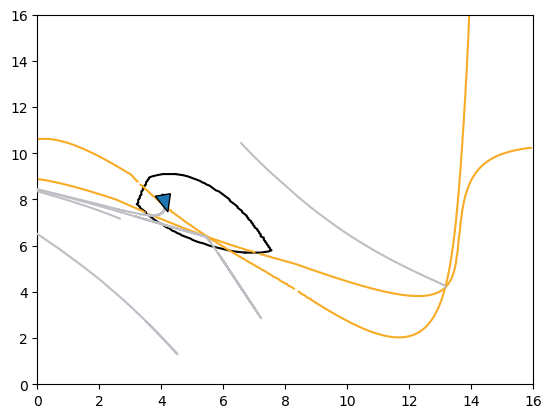

In [235]:
[[lb1,ub1],[lb3,ub3]] = [[0.3,.3],[.4,.4]]
# plot_HP_contours(18,[lb1],[ub1],[0],[viridian],plotavgs=True)
# plt.show()
# plot_HP_contours(18,[lb3],[ub3],[2],[xanthous],plotavgs=True)
# plt.show()
plot_HP_contours(18,[lb1,lb3],[ub1,ub3],[0,2],[xanthous,xanthous])
stepsize = 0.05
dur = 100000
time = np.arange(0,dur,stepsize)
repeats = int(200/40)
# traj = np.loadtxt("./Convenient HP Mechanisms/testrhobiastrack.dat").reshape((repeats,len(time),2))
# traj = np.loadtxt("./Convenient HP Mechanisms/tricksterbiastrack.dat").reshape((repeats,len(time),2))
for i in range(repeats):
    plt.plot(traj[i,:,0],traj[i,:,1],color=french_gray,zorder=3)
    # plt.scatter(traj[i,0,0],traj[i,0,1])
plt.arrow(traj[4,0,0], traj[4,0,1], traj[4,1000,0]-traj[4,0,0], traj[4,1000,1]-traj[4,0,1],head_width=.5,zorder=4)
plt.xlim(0,16)
plt.ylim(0,16)

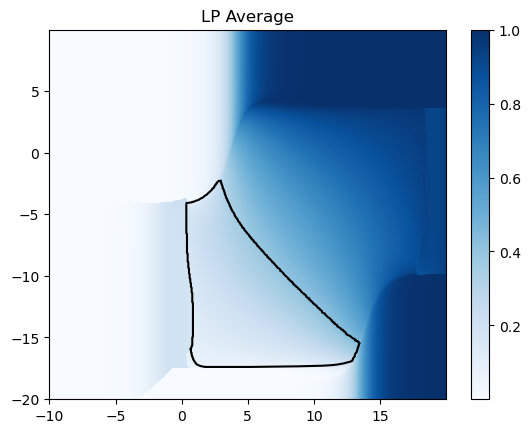

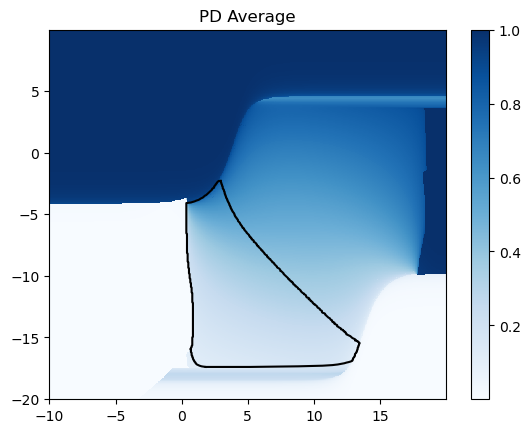

In [251]:
avgs,duty_cycle = get_avg_slice(19,'newrho')
col = plt.pcolormesh(par1res,par2res,avgs[:,:,0],cmap="Blues")
# cont = plt.contour(par1res,par2res,avgs[:,:,0],levels=[0.3],colors=xanthous)
cbar = plt.colorbar(col)
# cbar.add_lines(cont)
plot_outline(19,'k',True)
plt.title("LP Average")
plt.show()
col2 = plt.pcolormesh(par1res,par2res,avgs[:,:,2],cmap="Blues")
# cont = plt.contour(par1res,par2res,avgs[:,:,0],levels=[0.3],colors=xanthous)
cbar = plt.colorbar(col2)
# cbar.add_lines(cont)
plot_outline(19,'k',True)
plt.title("PD Average")
plt.show()